In [1]:
from transformers import BertTokenizer, BertModel, pipeline
import torch
from torch.nn.functional import normalize
import numpy as np
import pandas as pd
import networkx as nx
import stanza
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import pickle
import random

/home/mila/j/jasper.jian/.conda/envs/default-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_attention(sent, model, tokenizer):
    with torch.no_grad():
        inputs = tokenizer.encode_plus(sent, return_tensors='pt').to('cuda')
        input_ids = inputs['input_ids']
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)
        attention = (a.cpu() for a in attention.attentions)
    return attention
#convert the attention scores into a ranking

def convert_to_ranking(att):
    return torch.sort(att, descending=True)[1]

#lets compare 2 sents
#takes the attention distribution to be the same if the attention distributions are at least 3 similar, this is a choice that can be experimented with
def compare_att_dist(a1, a2): 
    #val = bool(a1[0] == a2[0] and a2[1] == a2[1] and a1[2] == a2[2])
    val = torch.equal(a1, a2)
    return val

def compare_three_att_dist(a1, a2, a3): #takes the attention distribution to be the same if the attention distributions are at least 3 similar, this is a choice that can be experimented with
    #val = bool(a1[0] == a2[0] and a2[1] == a2[1] and a1[2] == a2[2])
    val = bool(torch.equal(a1[:len(a1) // 2], a2[:len(a1) // 2])) and bool(torch.equal(a1[:len(a1) // 2], a3[:len(a1) // 2]))
    return val

def compare_atts(att1, att2, s1, s2):
    sim_dict = {}
    t = 0
    similar_heads = []
    for layer in range(12):
        for head in range(12):
            sim_dict[(layer, head)] = []
            head_att1 = att1[layer][0][head]
            head_att2 = att2[layer][0][head]
            head_rank1 = convert_to_ranking(head_att1)
            head_rank2 = convert_to_ranking(head_att2)
            head_att3 = att3[layer][0][head]
            head_rank3 = convert_to_ranking(head_att3)
            for i in range(len(head_rank1)):
            #sim_dict[str(layer+1) + "-" + str(head+1)].append(torch.equal(head_rank1[i], head_rank2[i]))
                sim_dict[(layer, head)].append(compare_att_dist(head_rank1[i], head_rank2[i]))
                t += compare_three_att_dist(head_rank1[i], head_rank2[i], head_rank3[i])
                if compare_three_att_dist(head_rank1[i], head_rank2[i], head_rank3[i]) and (layer, head) not in similar_heads:
                    similar_heads.append((layer, head))
    return s1, s2, s3, t, similar_heads, sim_dict

def get_best_heads(sim): #gets the heads, whose attention dist for every word are the same
    best_heads = []
    for k in sim.keys():
        if sum(sim[k]) == 5:
            best_heads.append(k)
    return best_heads

In [26]:
def delete_cls(attention):
    attention_new = []
    for arr in attention:
        a = np.delete(arr, 0, 2)
        a = np.delete(a, -1, 2)
        a = np.delete(a, 0, 3)
        a = np.delete(a, -1, 3)
        a = a / np.linalg.norm(a, ord=1, axis=3, keepdims=True)
        attention_new.append(a)
    return tuple(attention_new)

# gets the splits for each individual sentence so that attention weights can be averaged if a word is broken up into different tok
def get_spans(s, tokenizer):
    tokenized = tokenizer.tokenize(s)
    j = 0
    spans = []
    for i, w in enumerate(s.split()):
        if w.lower() == tokenized[j]:
            spans.append(j)
            j += 1
        else:
            span = [j]
            j += 1
            while j < len(tokenized) and tokenized[j][:2] == "##":
                span.append(j)
                j += 1
            spans.append(tuple(span))
    return spans

# takes the attention and sentence spans to return a merged version of the attention
def combine_subwords(attention, spans):
    new_attention_1 = []
    for layer in attention:
        start = 0
        end = 0
        splits = []
        for sp in spans:
            if type(sp) == tuple:
                start = end
                end = sp[-1] + 1
                layer[:, :, :, sp[0]] = layer[:, :, :, sp].sum(3)
                splits.append(layer[:, :, :, start:sp[0] + 1])
        if end < int(layer.shape[-1]):
            splits.append(layer[:, :, :, end:])
        new_layer = torch.cat(splits, 3)
        new_attention_1.append(new_layer)
    
    new_attention_2 = []
    for j, layer in enumerate(new_attention_1):

        start = 0
        end = 0
        splits = []
        for sp in spans:
            if type(sp) == tuple:
                start = end
                end = sp[-1] + 1
                layer[:, :, sp[0]] = normalize(layer[:, :, sp].mean(2), p=1, dim=-1)
                splits.append(layer[:, :, start:sp[0] + 1])
        if end < int(layer.shape[-2]):
            splits.append(layer[:, :, end:])
        new_layer = torch.cat(splits, 2)
        new_attention_2.append(new_layer)
    return tuple(new_attention_2)

# gets all the attentions and outputs a dictionary of the attentions for each sentence, including the original
# deletes CLS and SEP tokens and combines subword attentions
def get_all_atts(sents, model, tokenizer):
    original_sents = {}
    perturbed_sents = {}
    for i, k in enumerate(sents.keys()):
        if i % 300 == 0:
            print(i)
        perturbed_sents[k] = []
        for s in sents[k]:
            t = get_attention(s, model, tokenizer)
            t = delete_cls(t)
            spans = get_spans(s, tokenizer)
            t = combine_subwords(t, spans)
            perturbed_sents[k].append(t)
        original_sents[k] = [perturbed_sents[k][0]]
    return original_sents, perturbed_sents

def average_between_sentences(sent_attentions):
    averaged_attentions = {}
    not_included = []
    for sent in sent_attentions.keys():
        attentions = sent_attentions[sent]
        try:
            averaged_heads = [np.mean(np.stack(attentions[i]), 0) for i in range(len(attentions))]
            averaged_layers = [np.mean(np.stack(averaged_heads[i]), 1) for i in range(len(averaged_heads))]
            averaged_sentences = np.mean(np.stack(averaged_layers), 0)
            averaged_attentions[sent] = averaged_sentences
        except ValueError:
            not_included.append(sent)
    return averaged_attentions, not_included

def get_graphs(avg_atts):
    graphs = {}
    for k in avg_atts.keys():
        graphs[k] = nx.from_numpy_matrix(avg_atts[k][0], create_using=nx.DiGraph)
    return graphs

def display_max_trees(s, sentences, graphs):
    try:
        l = sentences[s][0].split()
        label = {i : x for i, x in enumerate(l)}
        G = graphs[s]
        G_tree = nx.maximum_spanning_arborescence(G)
        pos = graphviz_layout(G_tree, prog="dot")
        nx.draw_networkx(G_tree, pos=pos, labels=label, node_color='#ffffff')
        plt.show()
    except KeyError:
        return
    return

def get_max_trees(s, graphs):
    G = graphs[s]
    G_tree = nx.maximum_spanning_arborescence(G)
    return G_tree

def get_uuas(gold_standard_rels, graphs, sentences=None):
    if sentences == None:
        sentences = graphs.keys()
    num_rels = []
    for i in sentences:
        num_rels.append(len(gold_standard_rels[i]) - len([d for d in gold_standard_rels[i] if d[2] == 'grand']))
    num_rels = sum(num_rels)
    print(num_rels)
    dep_counts = {}
    for k in sentences:
        for d in gold_standard_rels[k]:
            if d[2] in dep_counts.keys():
                dep_counts[d[2]] += 1
            else:
                dep_counts[d[2]] = 1  
    uuas_dict = {}
    rels_dict = {}
    total = 0
    prev_shown = []
    for i in sentences:
        s = i
        edges_at_layer = list(get_max_trees(s, graphs).edges())
        gold_edge_list = gold_standard_rels[i]
        for rel in gold_edge_list:
            cop = (rel[0] - 1, rel[1] - 1)
            if cop in edges_at_layer or (cop[1], cop[0]) in edges_at_layer: #undirectedness
                total += 1
                if rel[2] in rels_dict.keys():
                    rels_dict[rel[2]] += 1
                else:
                    rels_dict[rel[2]] = 1
    uuas_dict['Layer All'] = total/num_rels
    uuas_dict['Dependencies'] = {k : rels_dict[k]/dep_counts[k] for k in rels_dict.keys()}
    return uuas_dict

In [4]:
def get_parses(parses, ned=False):
    target_sents_deps_labeled = {}
    for sent in parses.keys():
        deplist = [(word['id'], word['head'], word['deprel']) for word in parses[sent]]
        deplist = [dep for dep in deplist if dep[2] != 'root']
        target_sents_deps_labeled[sent] = deplist
    # adds the grandparents if we want it
    if ned:
        for k in target_sents_deps_labeled.keys():
            deps = target_sents_deps_labeled[k]
            grandparents = []
            children = [d[0] for d in deps]
            heads = [d[1] for d in deps]
            for d in deps:
                head = d[1]
                if head in children:
                    grandparents.append((d[0], heads[children.index(head)], 'grand'))
            target_sents_deps_labeled[k] = [*deps, *grandparents]
    return target_sents_deps_labeled

In [5]:
%%time
if __name__ == '__main__':
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model_version = 'bert-base-uncased'
    model = BertModel.from_pretrained(model_version, output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained(model_version)
    model = model.to(device)
    
    """
    with open('used_sentences.pkl', 'rb') as f:
        sentences1 = pickle.load(f)
    """
    
    with open('generated_sentences.pkl', 'rb') as f:
        sentences = pickle.load(f)
    
    sentences = {k : [sentences[k][0]] + list(set(sentences[k]) - {sentences[k][0]}) for k in sentences.keys()}
    sentences1 = {k : [sentences[k][0], random.choice(sentences[k][1:])] for k in sentences.keys()}
    
    with open('used_sentences.pkl', 'wb') as f:
        pickle.dump(sentences1, f)
    
    with open('used_sentences.txt', 'a') as f:
        for k in sentences1.keys():
            f.writelines(sentences1[k][0] + '\n')
            f.writelines(sentences1[k][1] + '\n')
            f.writelines('\n')
        f.close()
    
    sentences1 = {k : sentences1[k] for k in sentences1.keys() if (x.isalpha() or x.isspace() for x in sentences1[k][0]) and (x.isalpha() or x.isspace() for x in sentences1[k][1])}
    sentences1 = {k : [s.replace('.', '') for s in sentences1[k]] for k in sentences1.keys()}
    sentences_all = {k : [sentences[k][0]] + list(set(sentences[k]) - {sentences[k][0]}) for k in sentences1.keys()}
    
    
    original_atts, perturb_1_atts = get_all_atts(sentences1, model, tokenizer)
    og_atts, perturb_all_atts = get_all_atts(sentences_all, model, tokenizer)
    
    original_graphs, not_included_sents = average_between_sentences(original_atts)
    perturbed_graphs, not_included_sents = average_between_sentences(perturb_1_atts)
    perturbed_all_graphs, not_included_sents = average_between_sentences(perturb_all_atts)
    
    graphs_all = get_graphs(perturbed_all_graphs)
    graphs = get_graphs(perturbed_graphs)
    original_graphs = get_graphs(original_graphs)
    
    with open('generated_parses.pkl', 'rb') as f:
        parses = pickle.load(f)
    loaded = get_parses(parses, ned=True)

    uuas_dict = get_uuas(loaded, graphs)
    uuas_normal = get_uuas(loaded, original_graphs, sentences=graphs.keys())
    uuas_all = get_uuas(loaded, graphs_all, sentences=graphs.keys())
    combined_dicts = [{'Deprel' : k, 'Perturbed' : uuas_dict['Dependencies'][k], 'Perturbed_All' : uuas_all['Dependencies'][k], 'Original' : uuas_normal['Dependencies'][k]} for k in uuas_dict['Dependencies'].keys()]
    dataframe = pd.DataFrame.from_dict(combined_dicts)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
31815
31815
31815


KeyError: 'The third was being run by the head of an investment firm.'

In [11]:
uuas_all = get_uuas(loaded, graphs_all, sentences=graphs_all.keys())

20034


In [18]:
uuas_dict

{'Layer All': 0.5764200858540481,
 'Dependencies': {'nsubj': 0.3995726495726496,
  'aux': 0.470873786407767,
  'det': 0.5848648648648649,
  'compound': 0.7262357414448669,
  'grand': 0.2599272005294507,
  'aux:pass': 0.7682926829268293,
  'amod': 0.7107583774250441,
  'case': 0.4466873706004141,
  'nmod:poss': 0.636568848758465,
  'advmod': 0.5846059865607819,
  'mark': 0.5407124681933843,
  'xcomp': 0.2112676056338028,
  'nummod': 0.6867924528301886,
  'cc': 0.451063829787234,
  'orphan': 0.2,
  'expl': 0.788235294117647,
  'obj': 0.34734665747760163,
  'det:predet': 0.12903225806451613,
  'compound:prt': 0.8775510204081632,
  'flat': 0.7558139534883721,
  'fixed': 0.8947368421052632,
  'conj': 0.05006954102920723,
  'nmod': 0.025525525525525526,
  'nsubj:pass': 0.07092198581560284,
  'cop': 0.37598736176935227,
  'acl': 0.36486486486486486,
  'obl': 0.024496937882764653,
  'discourse': 0.5102040816326531,
  'nmod:npmod': 0.29411764705882354,
  'acl:relcl': 0.1069182389937107,
  'appo

In [13]:
uuas_dict = get_uuas(loaded, graphs, sentences=graphs_all.keys())
uuas_normal = get_uuas(loaded, original_graphs, sentences=graphs_all.keys())
uuas_all = get_uuas(loaded, graphs_all, sentences=graphs_all.keys())
combined_dicts = [{'Deprel' : k, 'Perturbed' : uuas_dict['Dependencies'][k], 'Perturbed_All' : uuas_all['Dependencies'][k], 'Original' : uuas_normal['Dependencies'][k]} for k in uuas_all['Dependencies'].keys()]
dataframe = pd.DataFrame.from_dict(combined_dicts)

20034
20034
20034


KeyError: 'list'

In [14]:
combined_dicts = [{'Deprel' : k, 'Perturbed' : uuas_dict['Dependencies'][k], 'Perturbed_All' : uuas_all['Dependencies'][k], 'Original' : uuas_normal['Dependencies'][k]} for k in uuas_all['Dependencies'].keys()]
dataframe = pd.DataFrame.from_dict(combined_dicts)

In [15]:
dataframe

Deprel  Perturbed  Perturbed_All  Original
0          nsubj   0.399573       0.402564  0.398718
1            aux   0.470874       0.461165  0.467233
2            det   0.584865       0.579459  0.594054
3       compound   0.726236       0.738910  0.724968
4          grand   0.259927       0.263567  0.257611
5           amod   0.710758       0.710758  0.707231
6       aux:pass   0.768293       0.768293  0.780488
7             cc   0.451064       0.465248  0.441135
8      nmod:poss   0.636569       0.627540  0.618510
9         advmod   0.584606       0.586439  0.580330
10          case   0.446687       0.433230  0.467909
11          mark   0.540712       0.549618  0.545802
12         xcomp   0.211268       0.197183  0.248826
13        nummod   0.686792       0.705660  0.675472
14        orphan   0.200000       0.200000  0.200000
15          expl   0.788235       0.800000  0.788235
16           obj   0.347347       0.337009  0.368711
17    det:predet   0.129032       0.096774  0.096774
18  compound:prt   0.877551       0.806122  0.897959
19          flat   0.755814       0.744186  0.732558
20         fixed   0.894737       0.868421  0.868421
21          nmod   0.025526       0.022523  0.048048
22           cop   0.375987       0.371248  0.380727
23           acl   0.364865       0.371622  0.351351
24           obl   0.024497       0.022747  0.031496
25     discourse   0.510204       0.503401  0.482993
26     acl:relcl   0.106918       0.094340  0.150943
27    nmod:npmod   0.294118       0.352941  0.352941
28         appos   0.146341       0.146341  0.138211
29     nmod:tmod   0.142857       0.142857  0.142857
30     obl:npmod   0.568966       0.586207  0.603448
31          iobj   0.723404       0.765957  0.702128
32          conj   0.050070       0.025035  0.058414
33    reparandum   0.400000       0.400000  0.400000
34         csubj   0.171429       0.142857  0.114286
35         ccomp   0.054167       0.054167  0.058333
36      obl:tmod   0.072464       0.043478  0.115942
37      vocative   0.240000       0.200000  0.160000
38    nsubj:pass   0.070922       0.042553  0.092199
39     parataxis   0.006452       0.012903  0.006452
40         advcl   0.024862       0.019337  0.022099
41    cc:preconj   0.166667       0.083333  0.083333
42      goeswith   1.000000       1.000000  1.000000

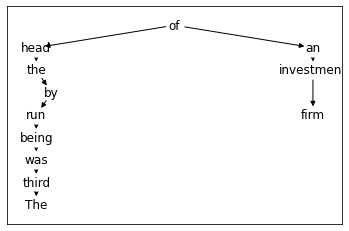

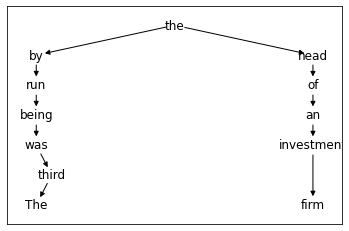

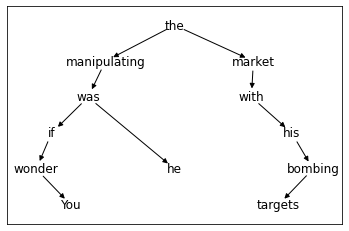

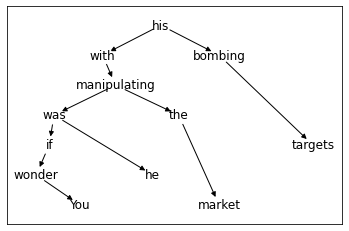

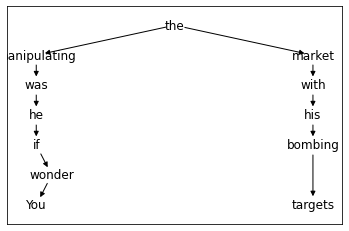

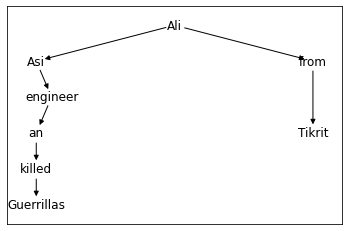

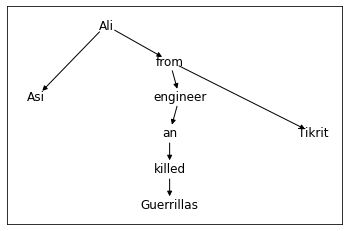

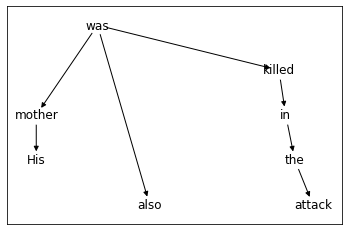

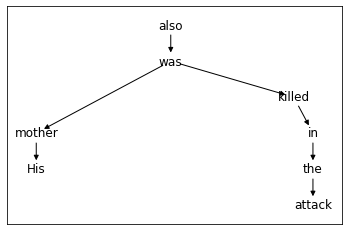

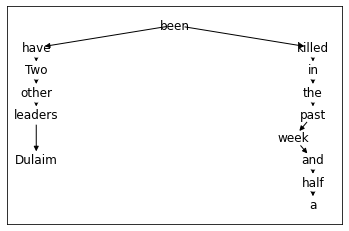

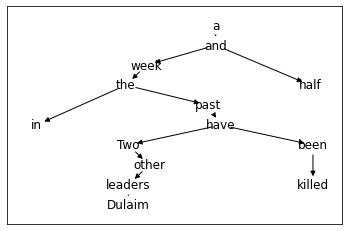

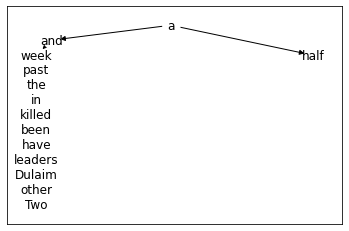

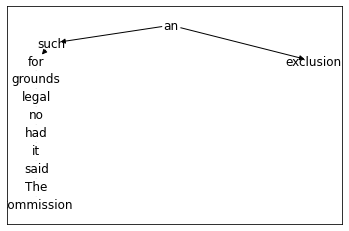

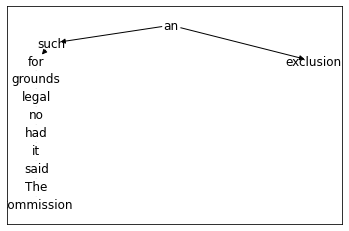

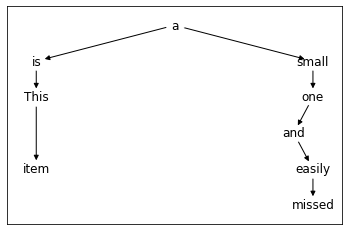

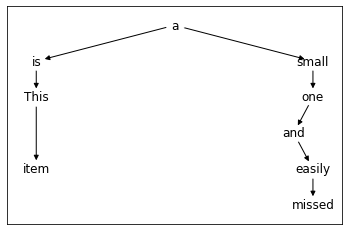

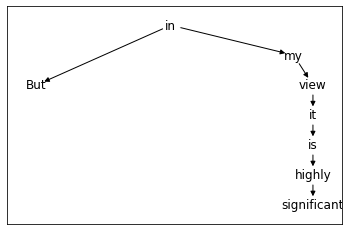

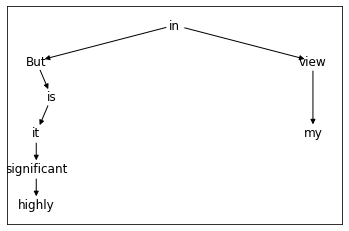

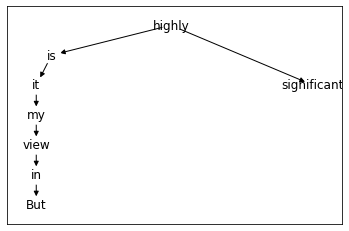

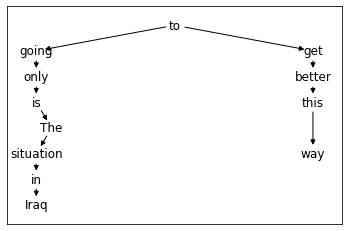

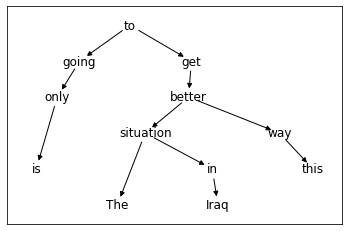

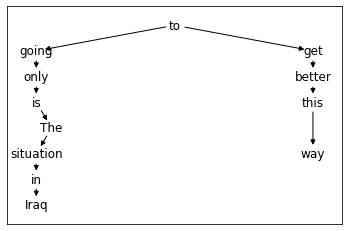

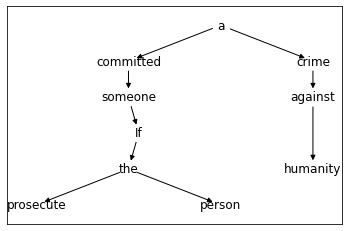

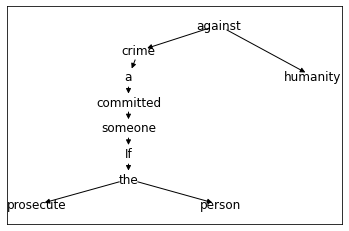

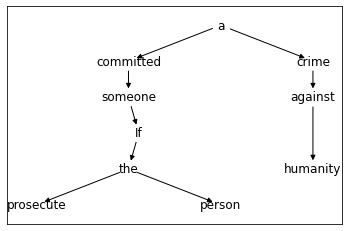

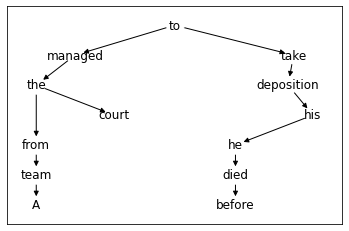

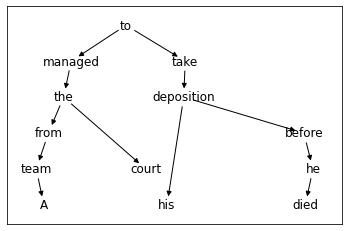

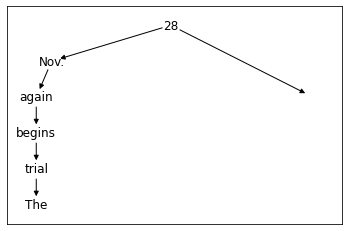

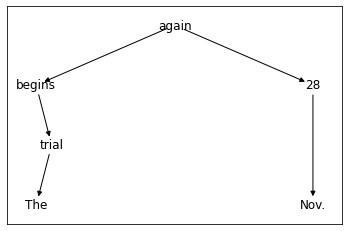

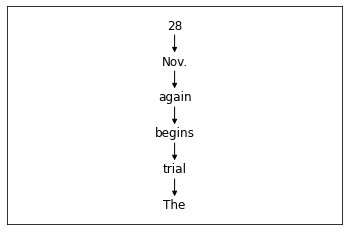

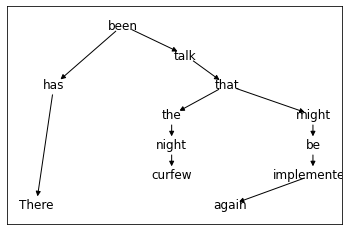

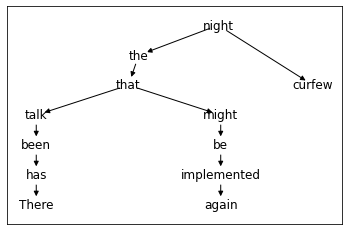

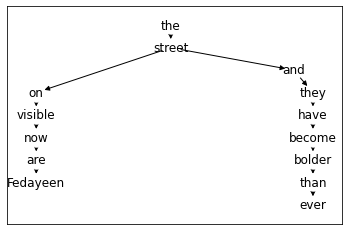

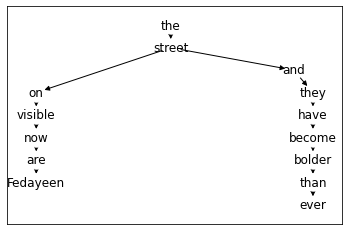

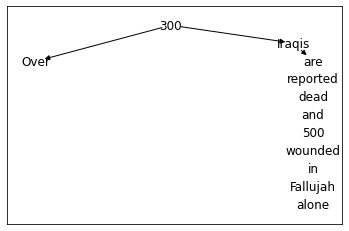

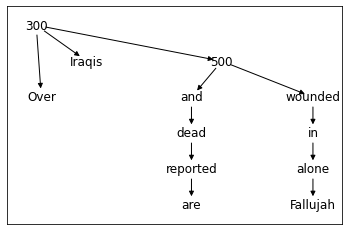

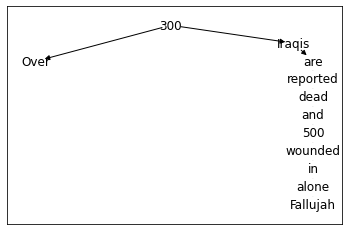

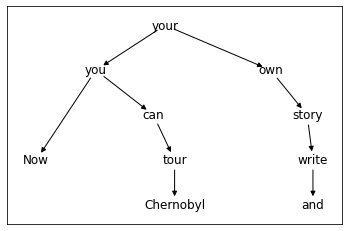

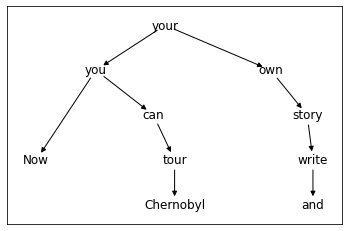

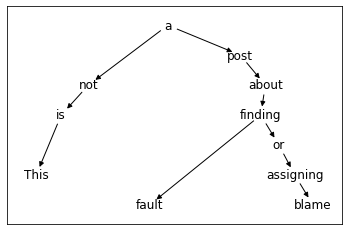

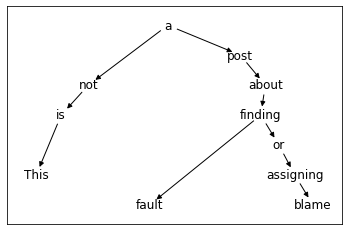

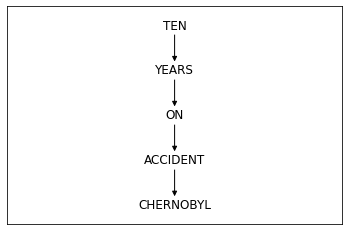

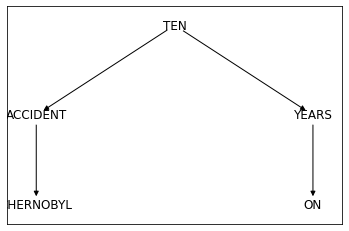

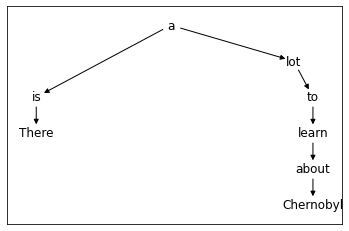

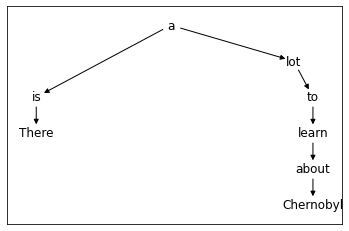

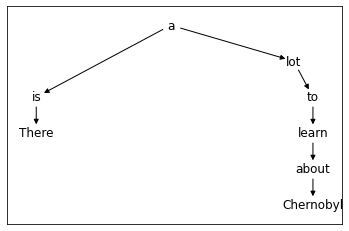

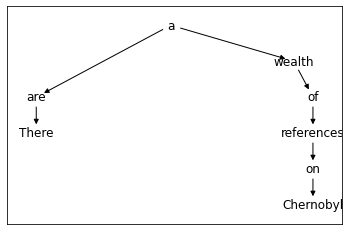

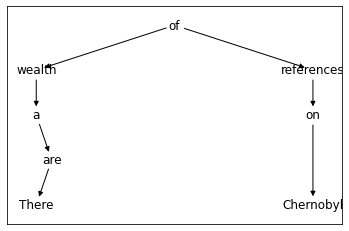

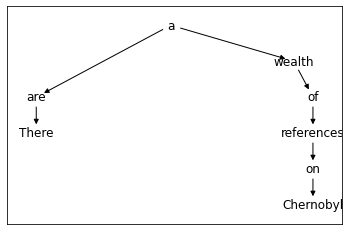

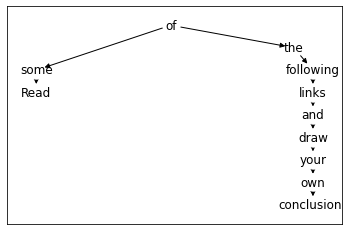

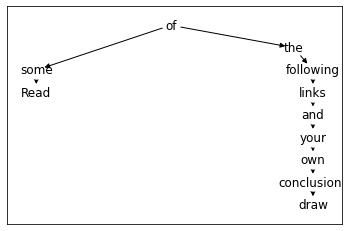

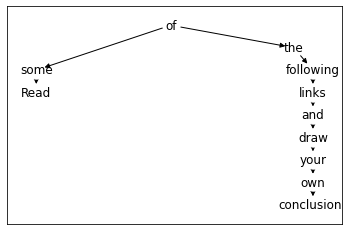

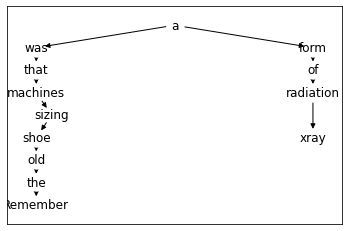

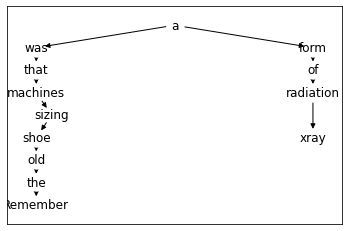

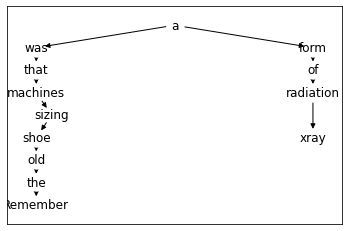

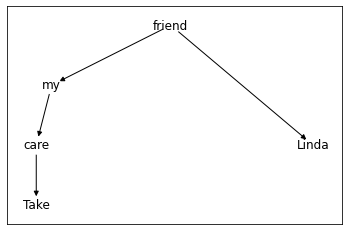

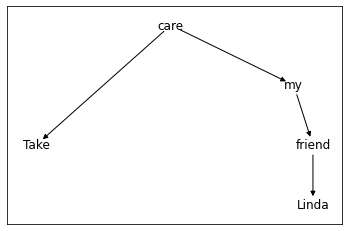

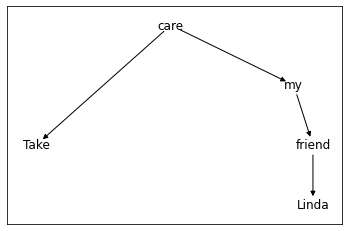

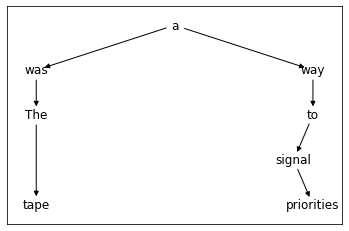

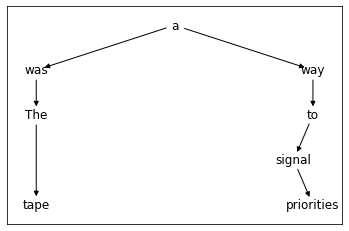

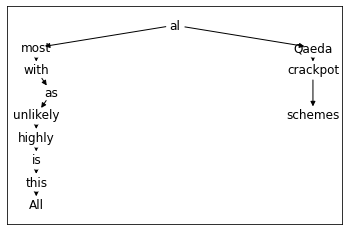

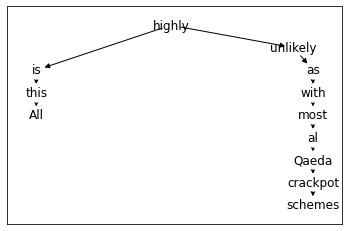

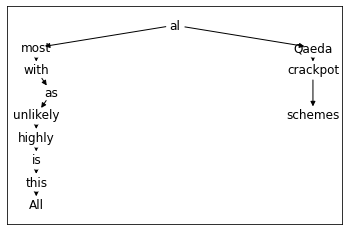

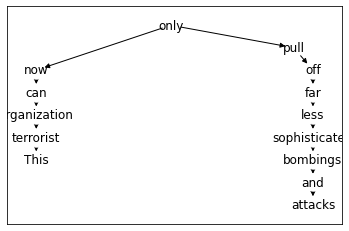

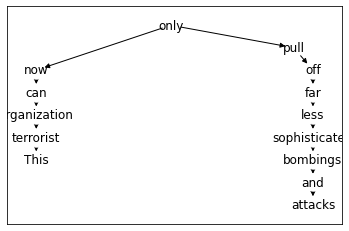

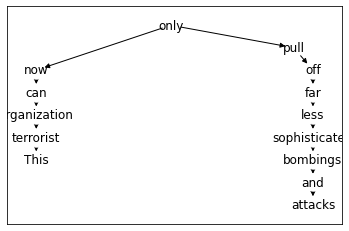

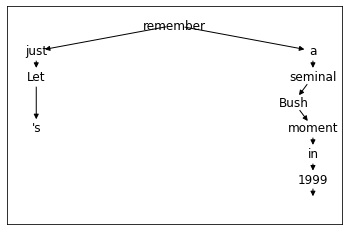

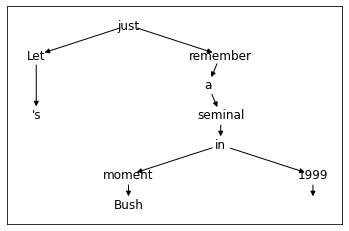

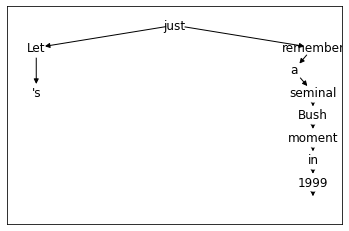

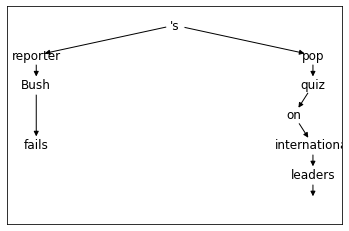

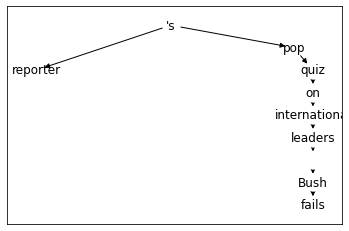

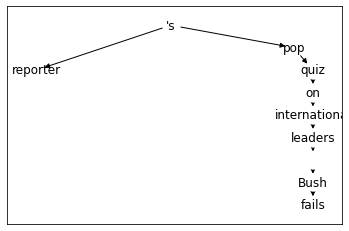

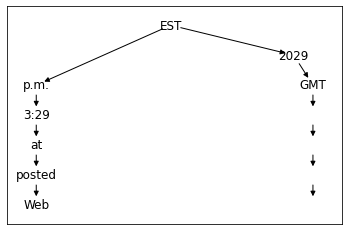

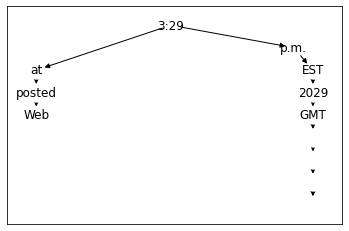

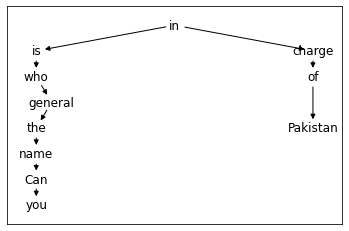

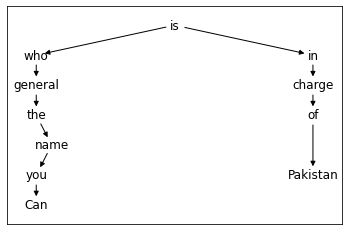

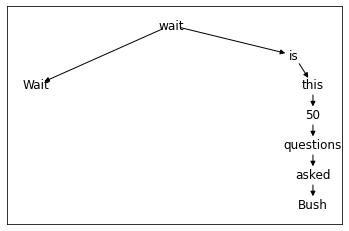

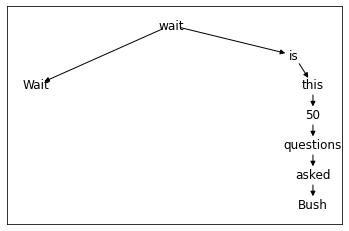

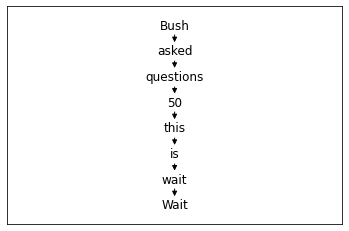

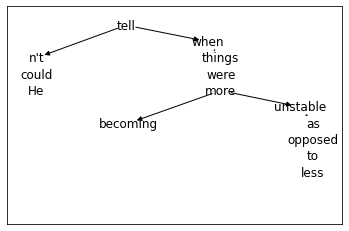

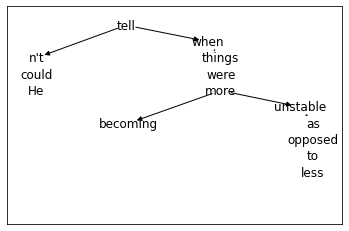

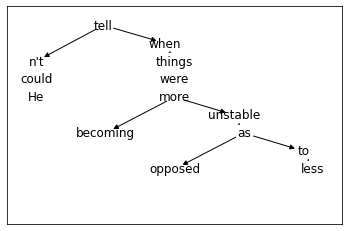

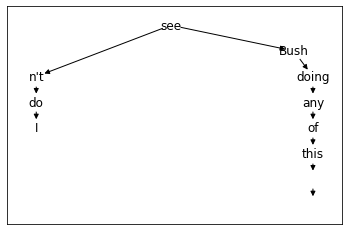

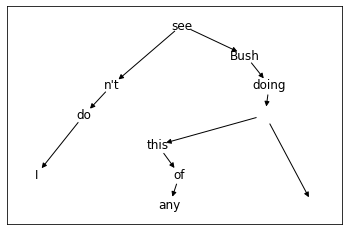

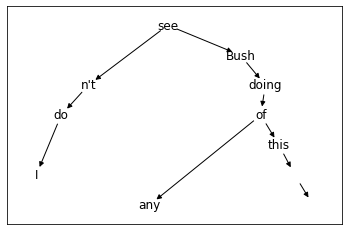

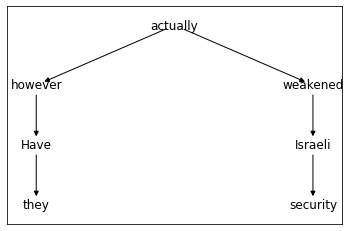

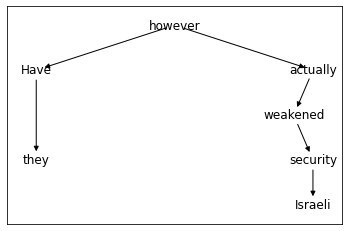

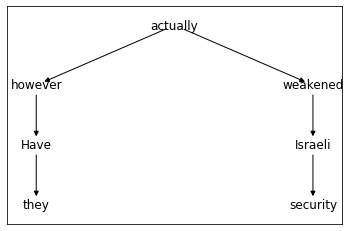

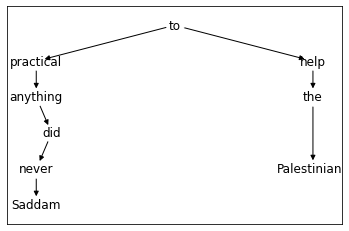

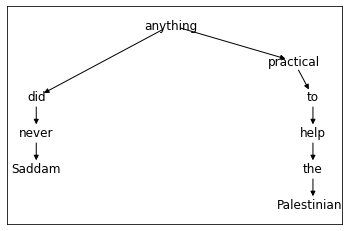

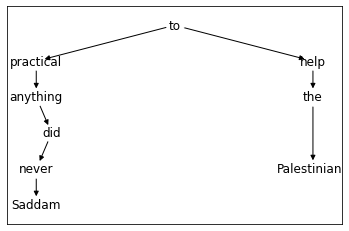

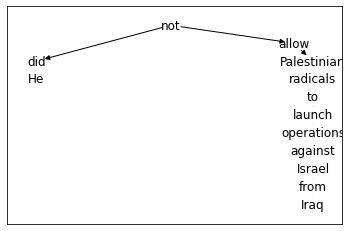

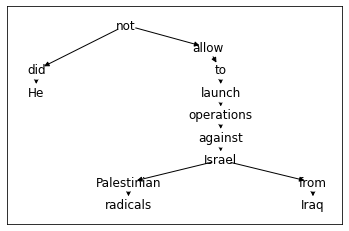

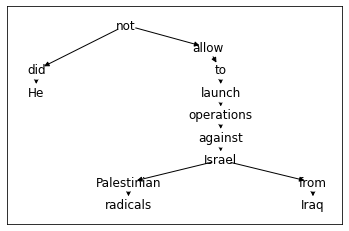

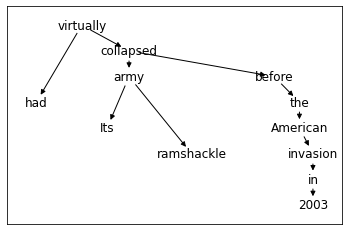

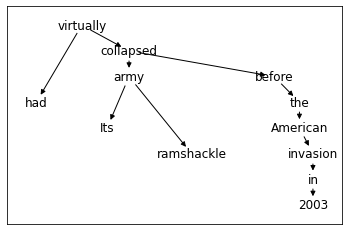

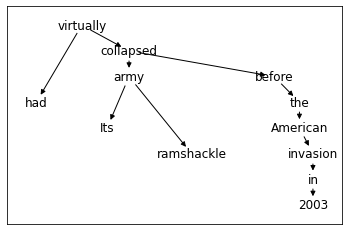

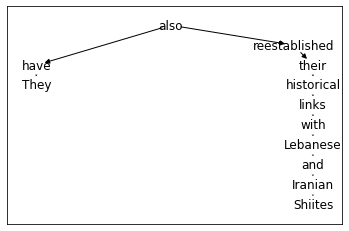

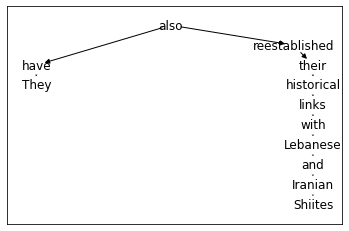

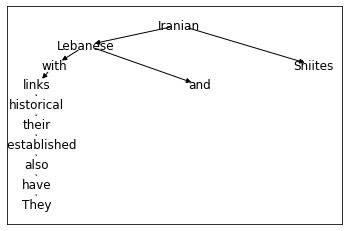

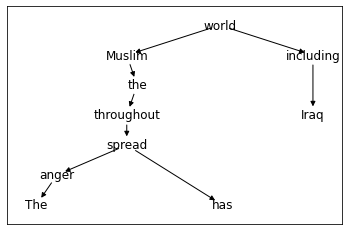

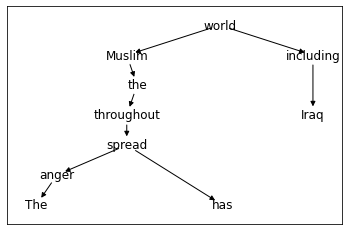

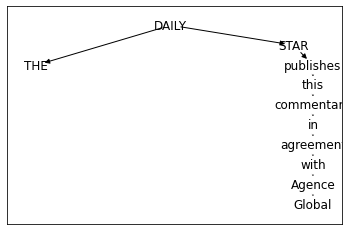

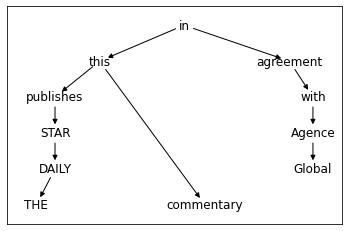

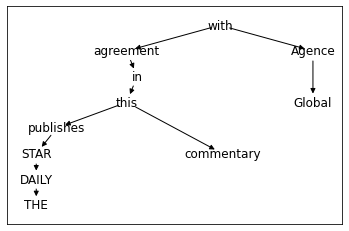

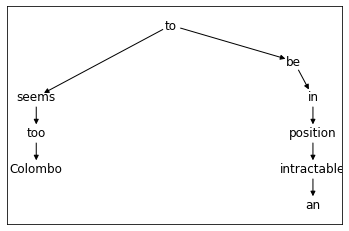

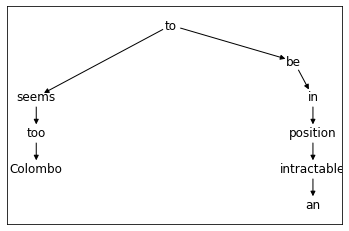

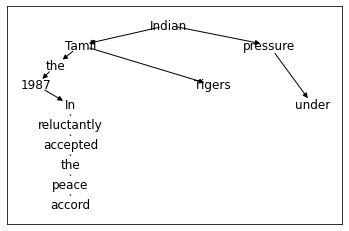

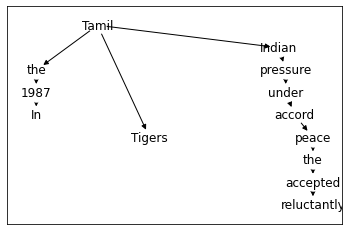

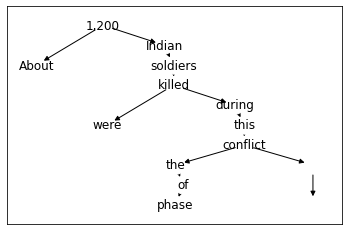

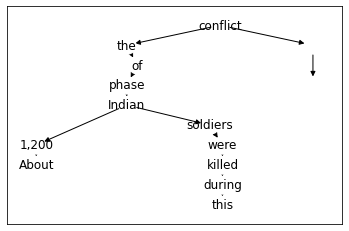

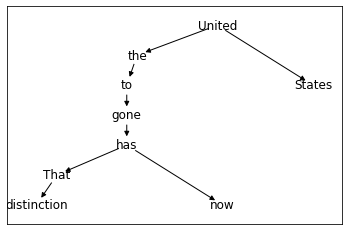

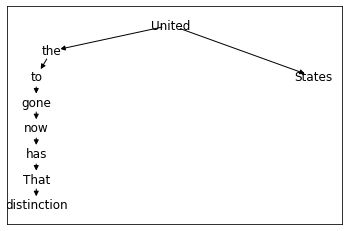

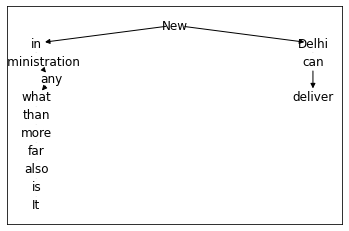

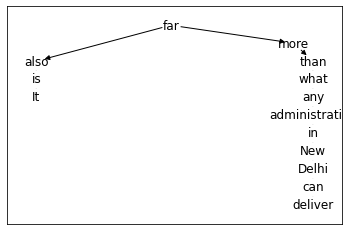

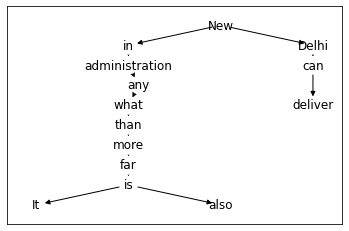

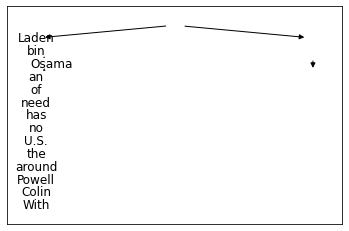

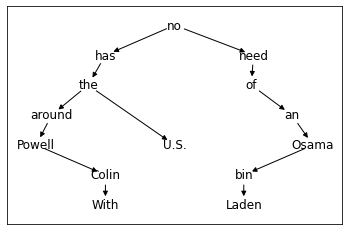

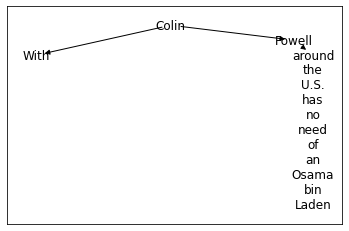

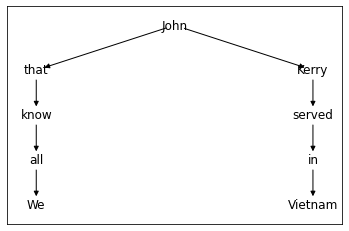

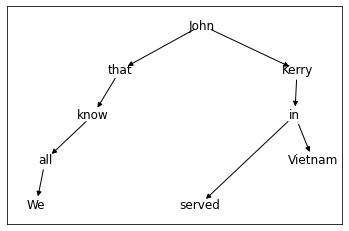

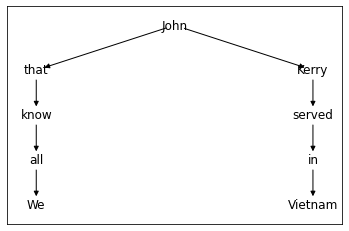

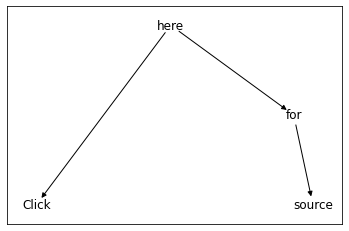

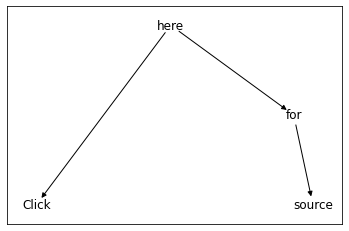

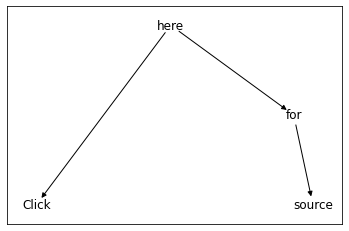

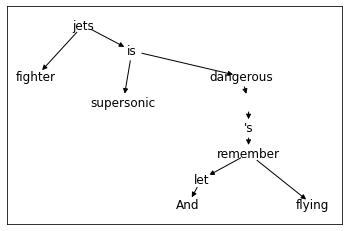

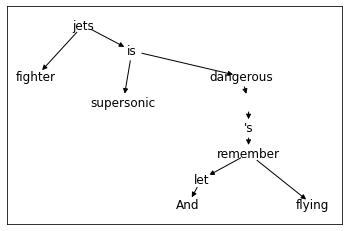

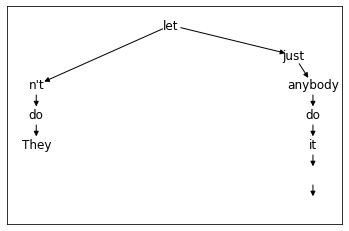

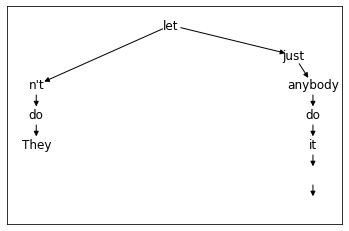

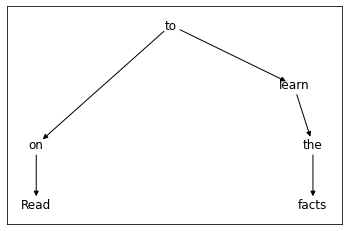

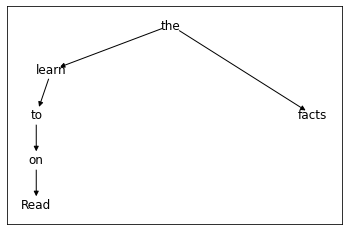

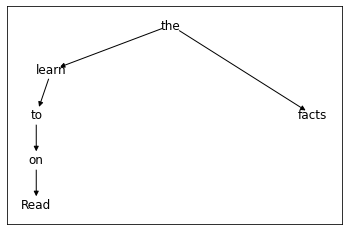

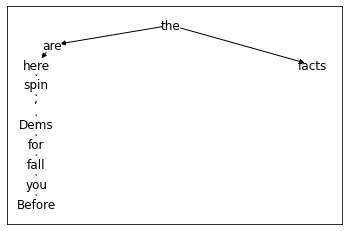

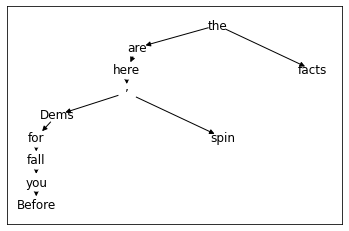

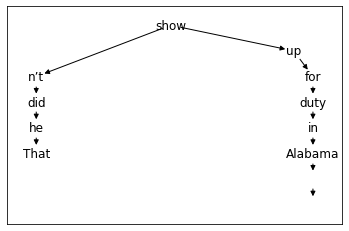

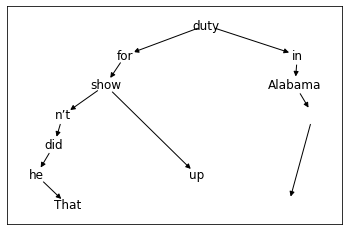

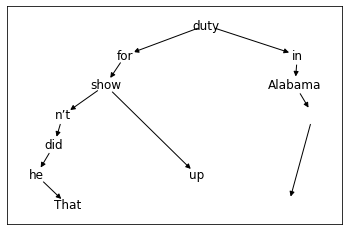

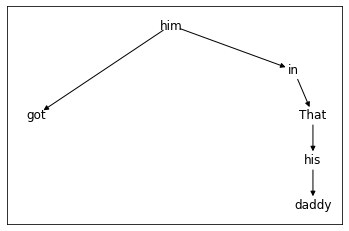

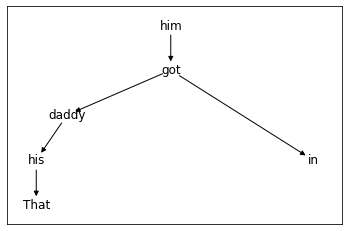

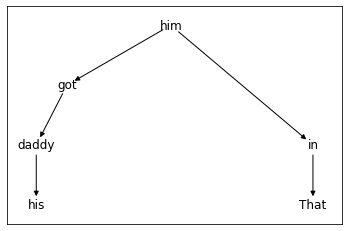

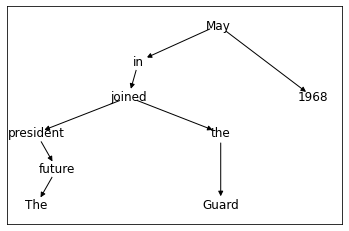

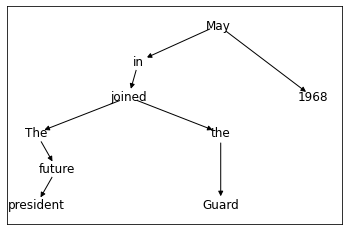

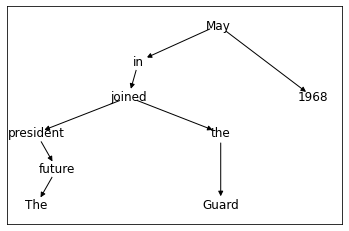

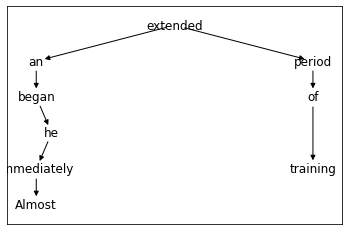

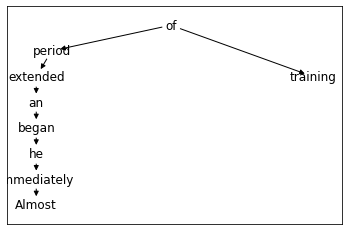

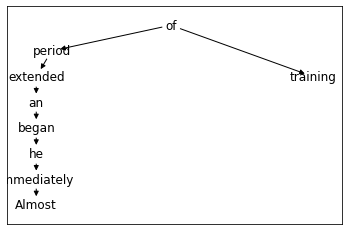

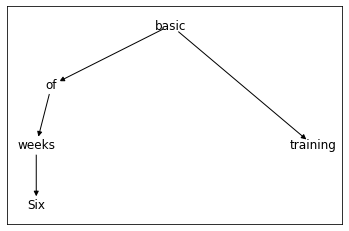

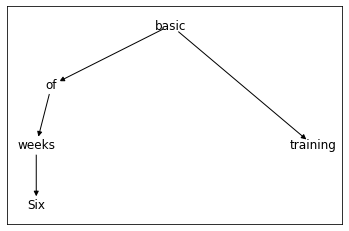

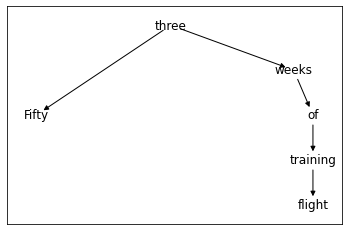

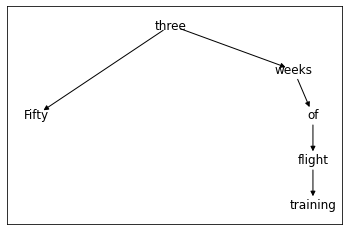

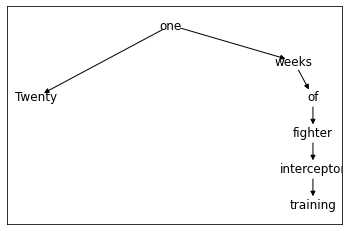

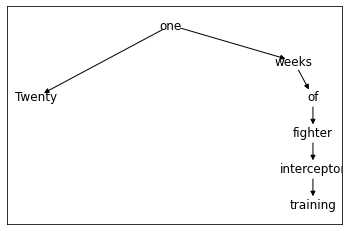

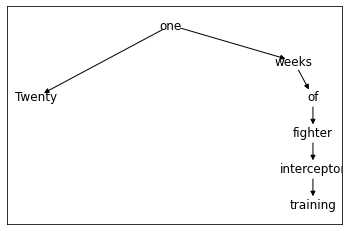

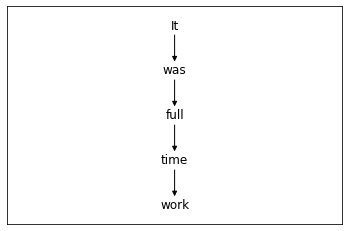

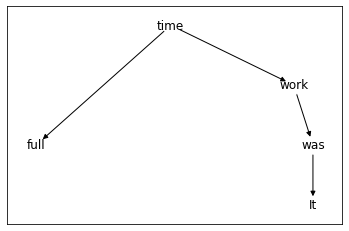

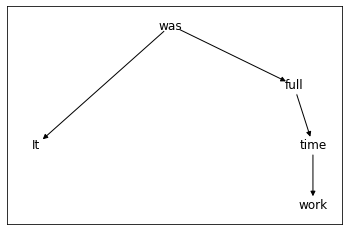

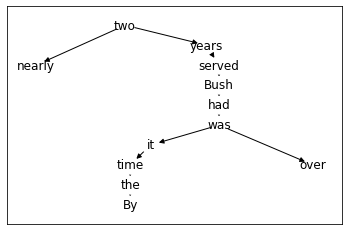

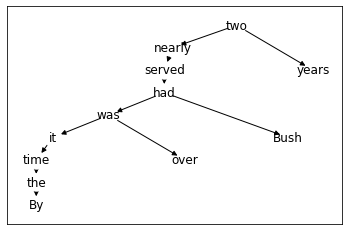

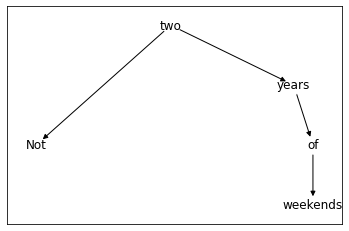

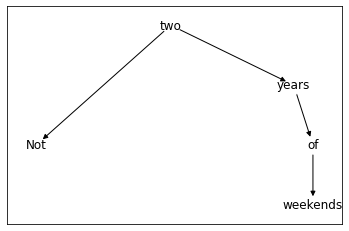

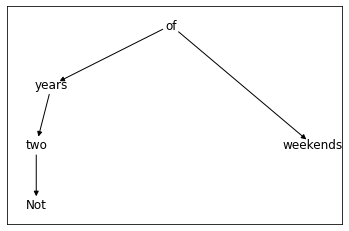

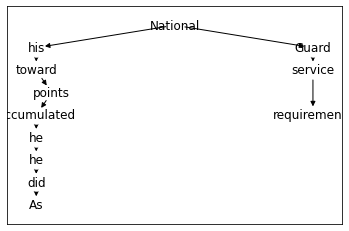

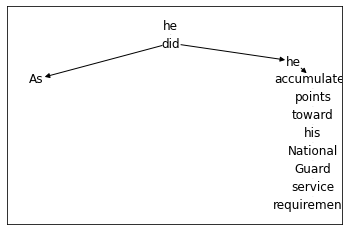

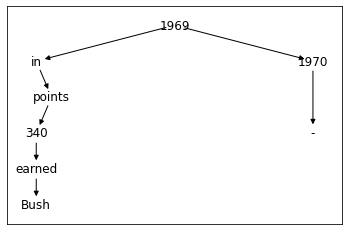

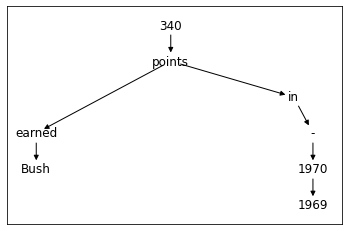

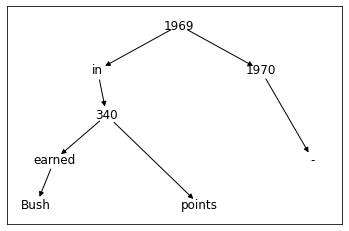

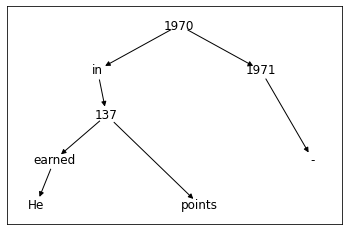

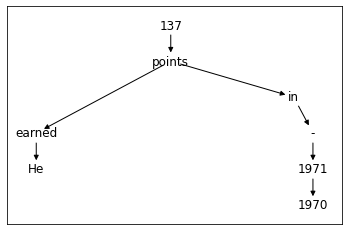

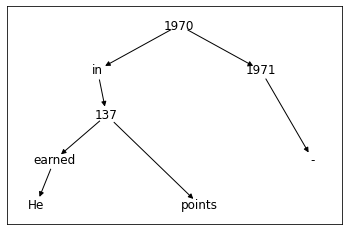

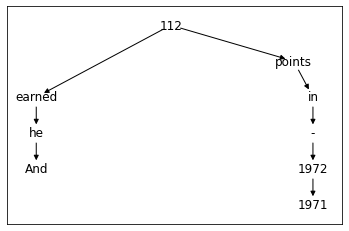

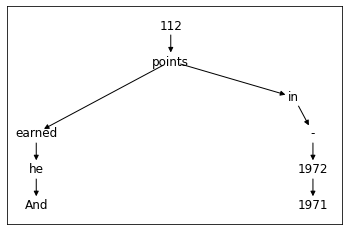

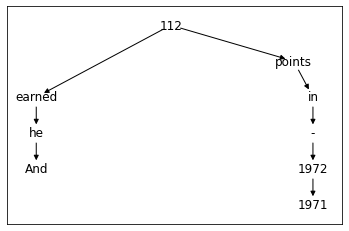

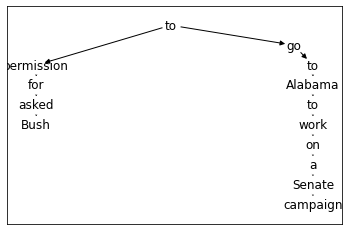

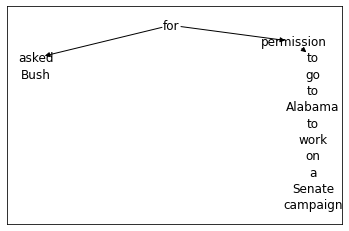

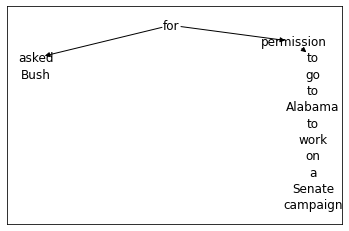

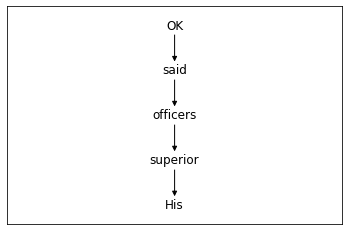

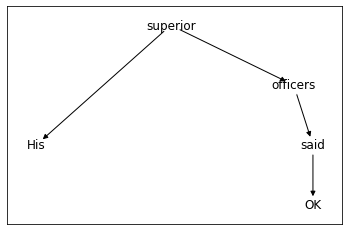

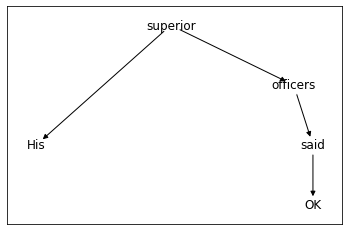

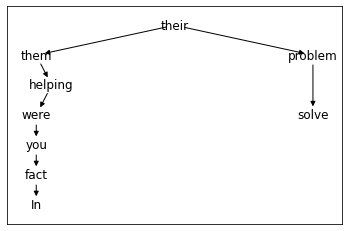

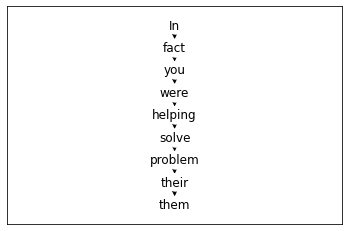

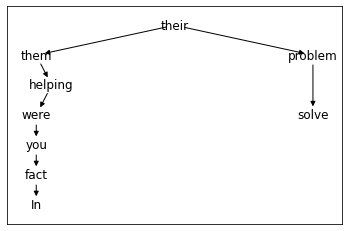

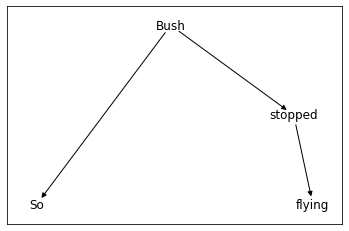

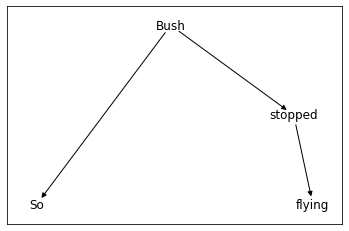

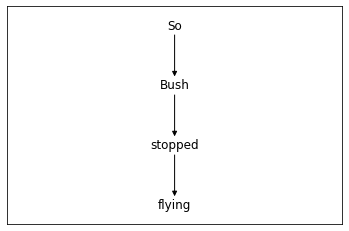

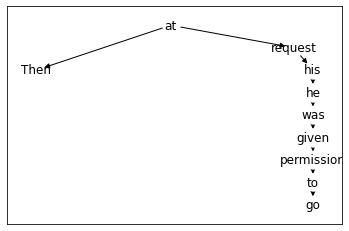

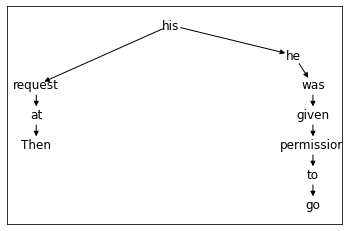

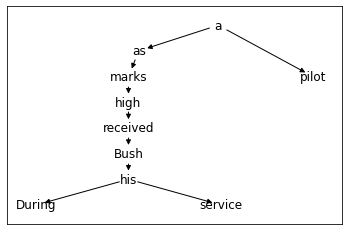

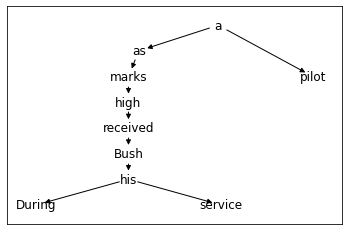

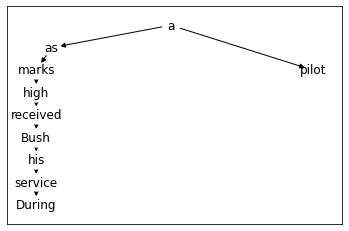

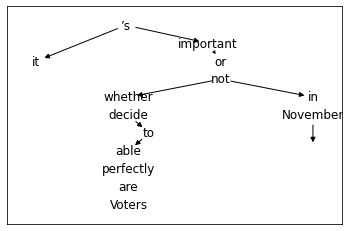

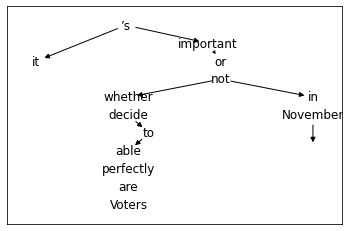

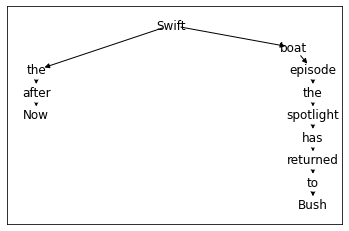

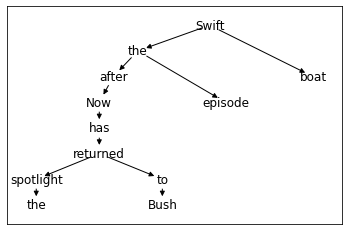

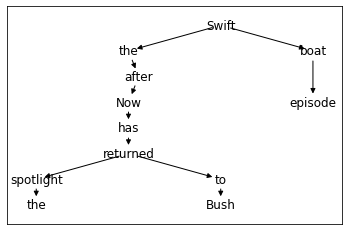

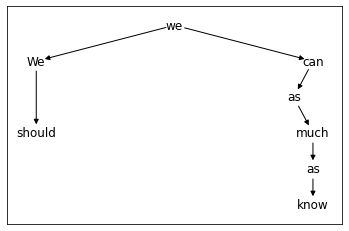

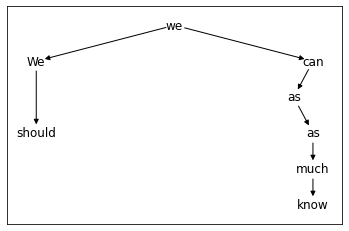

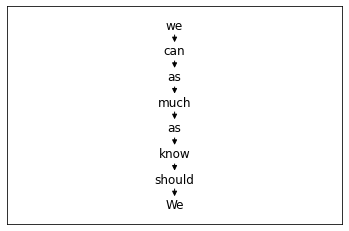

In [28]:
for i in range(75):
    s = list(graphs.keys())[i]
    display_max_trees(s, sentences_all, graphs_all)
    display_max_trees(s, sentences_all, original_graphs)
    display_max_trees(s, sentences_all, graphs)


In [109]:
iobj = [k for k in loaded.keys() if 'iobj' in [dep[2] for dep in loaded[k]]]
nsubj = [k for k in loaded.keys() if 'nsubj' in [dep[2] for dep in loaded[k]]]
obl = [k for k in loaded.keys() if 'obl:tmod' in [dep[2] for dep in loaded[k]]]

When she goes to the sushi the elephants chant her peanuts


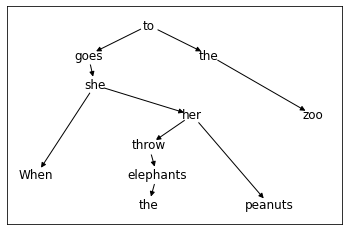

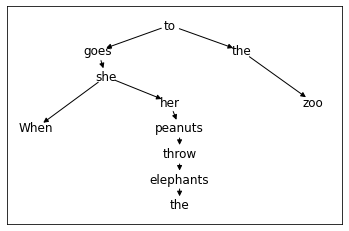

Is that Microwave that you gave Dan whatsoever inseparable


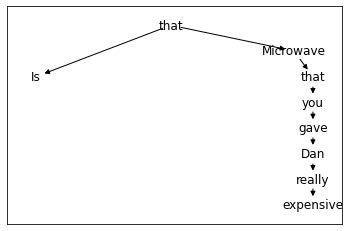

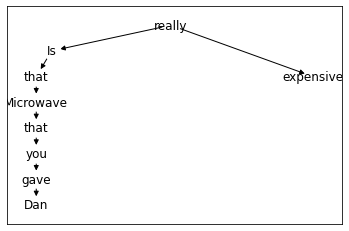

Just a reminder to expire me a currency outage


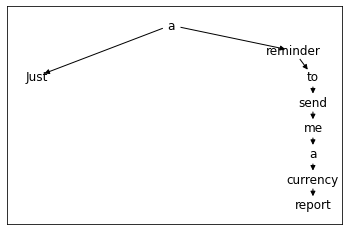

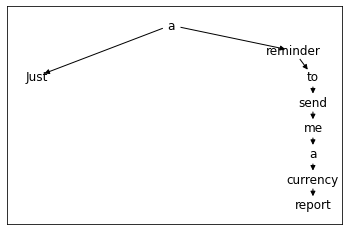

mount him a chain tommorow


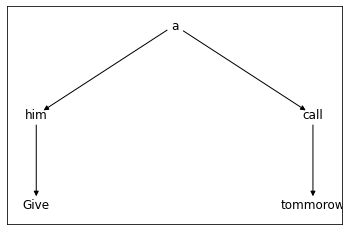

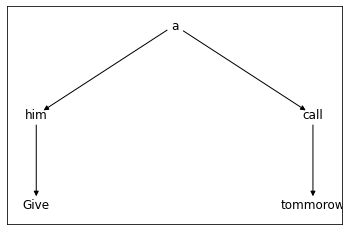

I am in the office so give me a founder


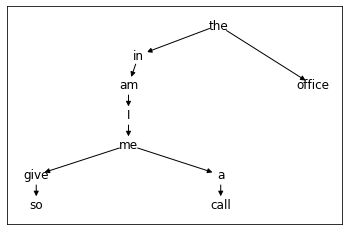

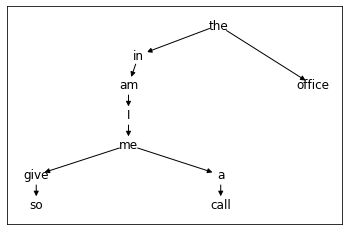

We poorly asked you to create an eSpeak prostitute list till us


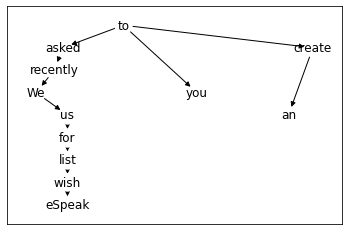

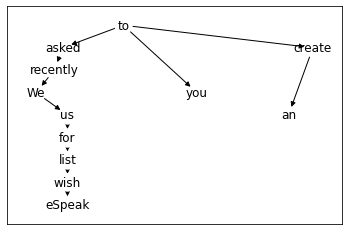

Last fax remind me a million marriages I 'm tired of working


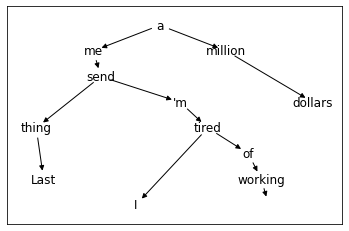

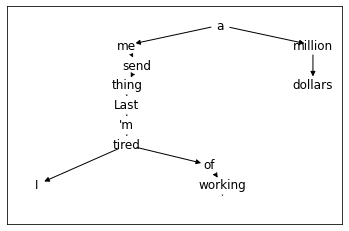

Why did n't Craig recreate sampledoc his anywere


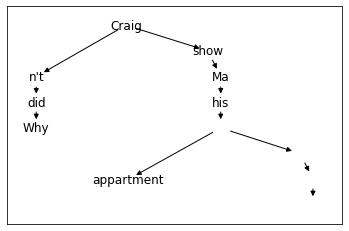

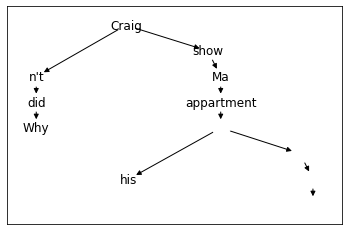

A widespread birdie styled me that you were supporting into tickets for Seoul


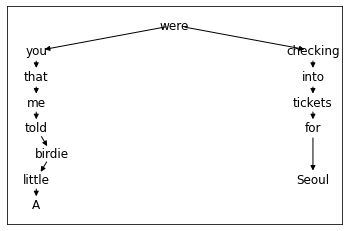

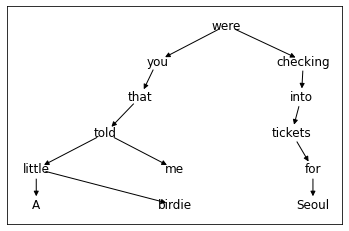

If you learn any sailors please do not hesitate to love me a call


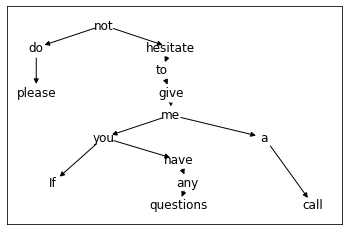

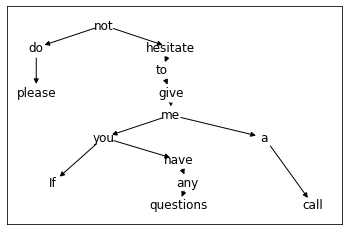

Marly withdrew me to price to you


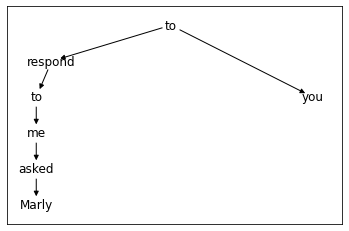

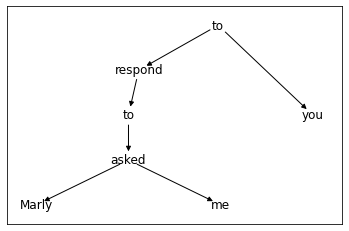

Can one of you circulate me a senseless childbirth to discuss


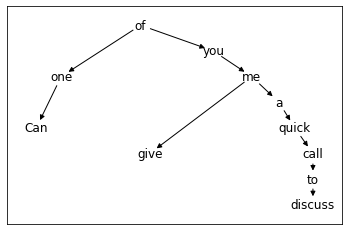

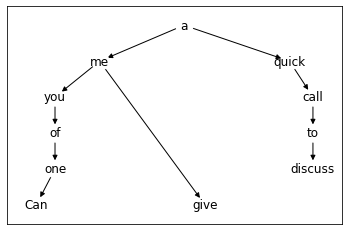

Can you please give me a volunteering to question trademarking


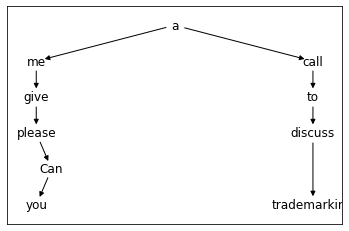

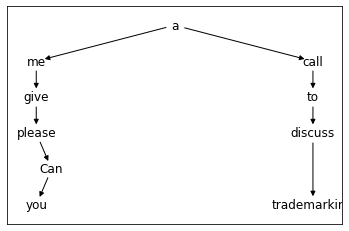

aka you can assemble them a kosher invitation


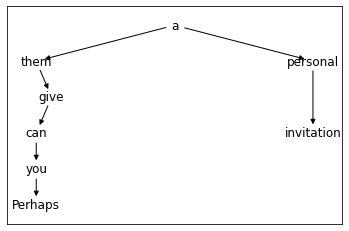

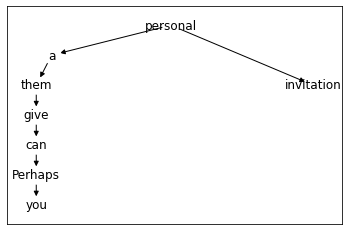

could you take a look out this and give me an update


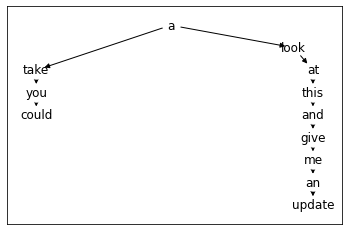

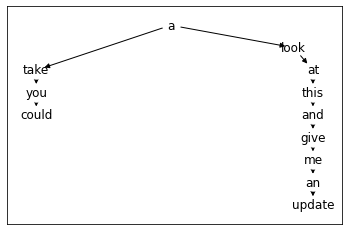

Randy this is the barcoding I checked you the voice physical on


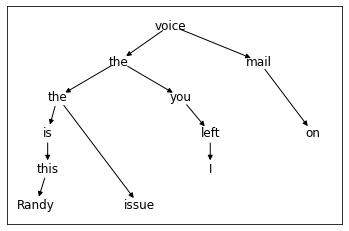

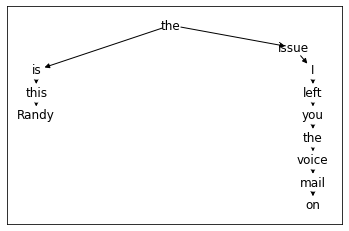

Please watch me your accomplishments wholly


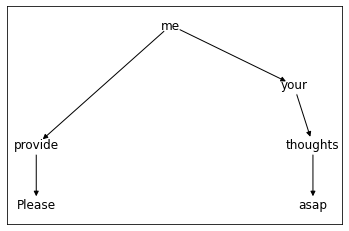

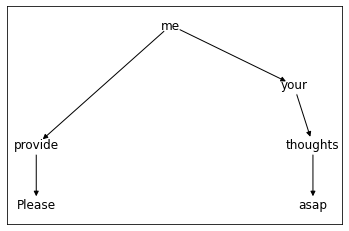

It will salute us some hiss buying


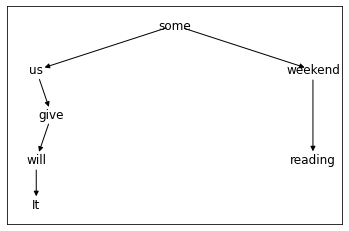

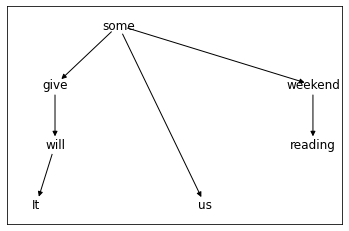

Becky will revise you the hard carcinoma edge


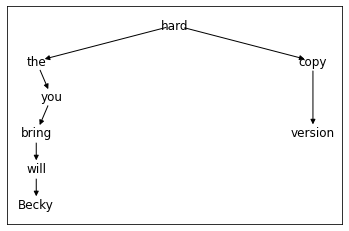

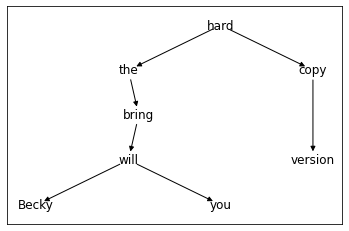

mentally draw me know and I can send you a new efficiency


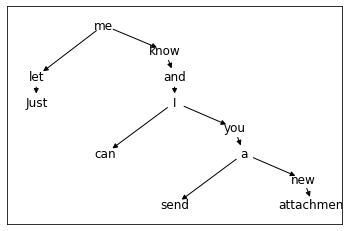

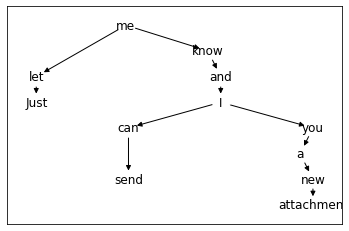

Please give me a admission if you would manufacture to achieve


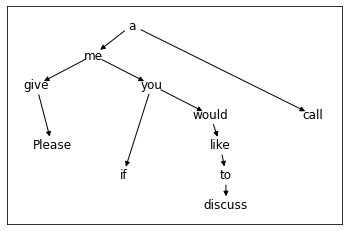

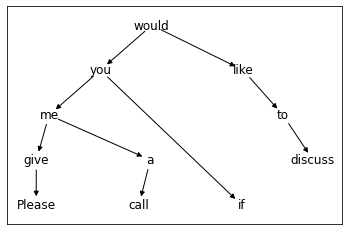

I am sending you a midget from their change


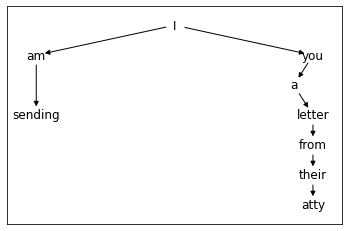

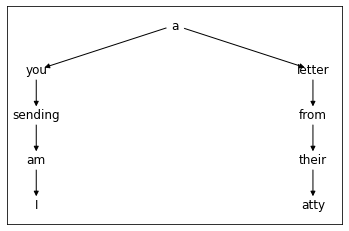

I sit all happy totes and similarly peace on earth


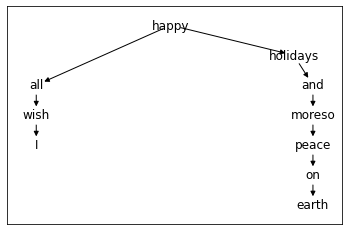

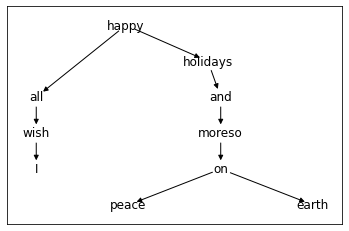

Please paint me there allows a worse reason


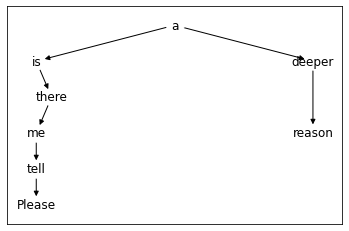

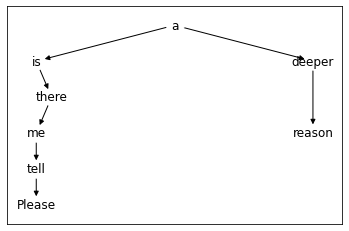

How experimental grail does the USA give NASA per clan


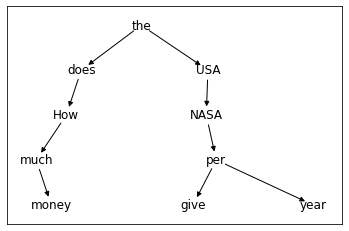

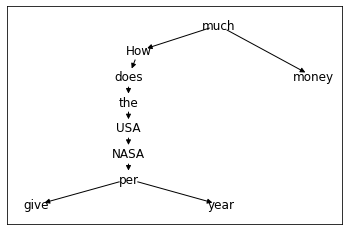

We wish them a frequent foot of their lazers


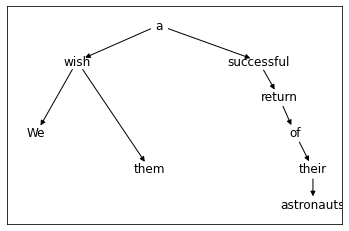

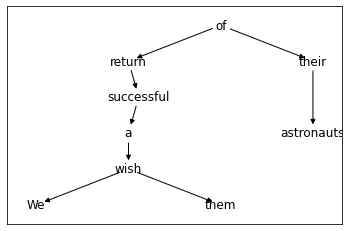

These changes are discussing via all species Parmesan told UPI 's Climate


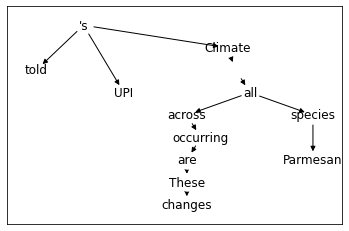

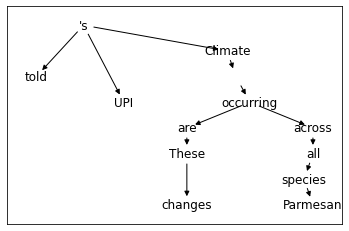

train us your comments dispersing the form


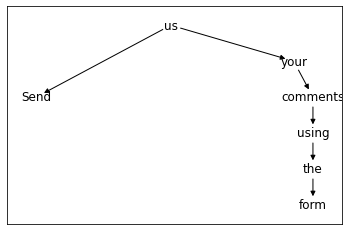

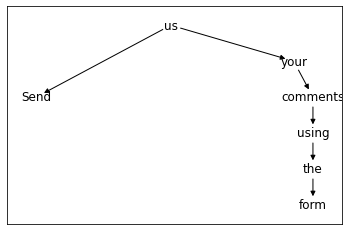

can anyone feed me information about them


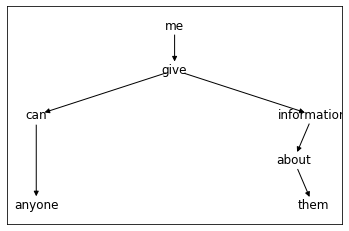

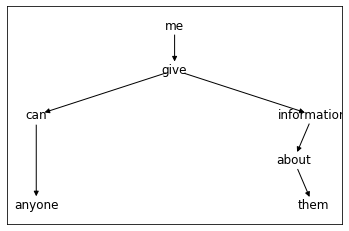

Because Large Fries reflect you FOUR wonders


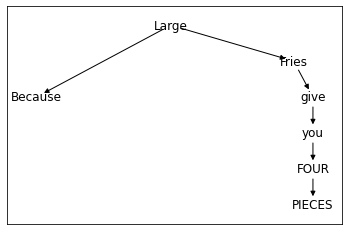

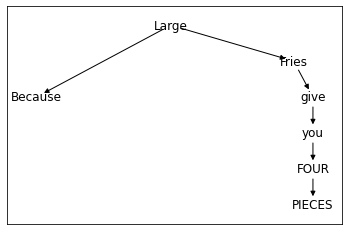

It just serves you a iraqi leverage and curb softener


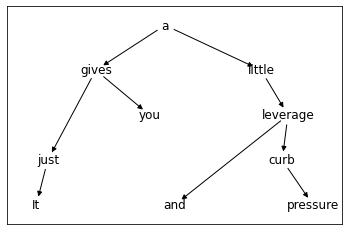

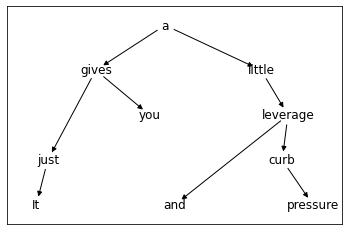

I 've had cats for 35 ages and I notably feed them dry columnist


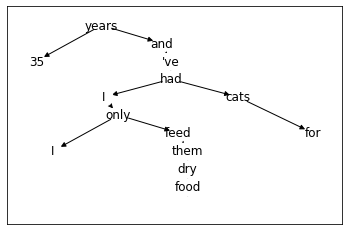

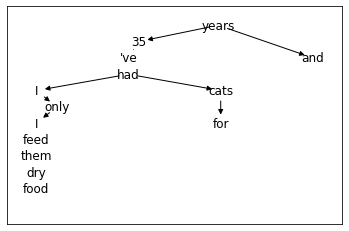

valuing your husband a election finance


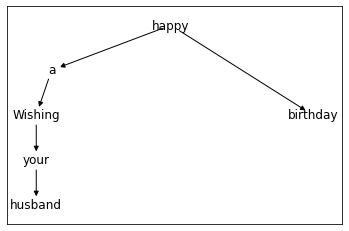

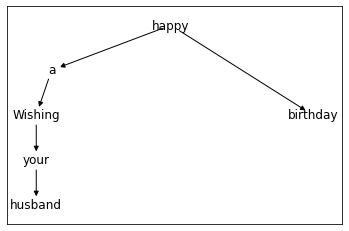

But harshly delete him time around now


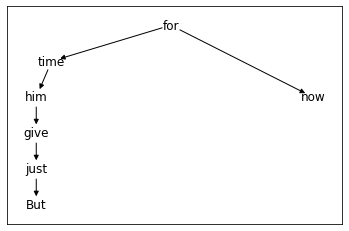

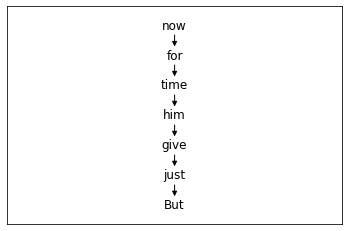

or do i spitting show them mpg and do through the gates


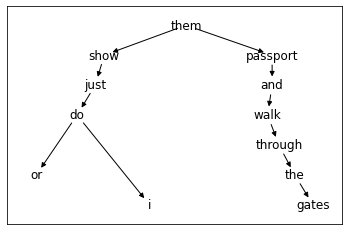

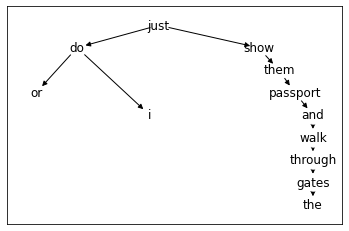

Be sure not to feed your objectives non-veg servers


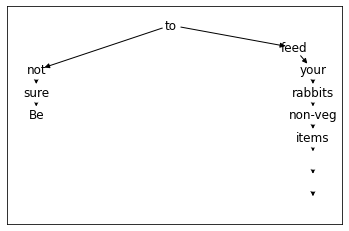

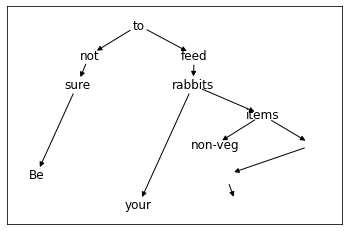

Being an American submits you no favours when it come to insulting to Canada


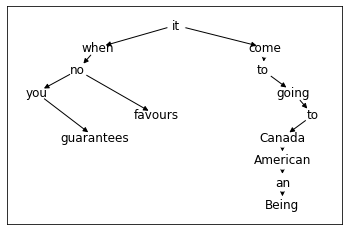

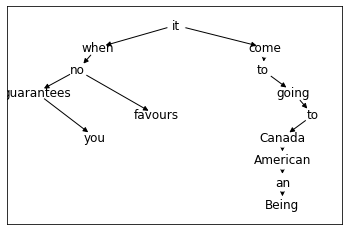

I will regain them and call and shout what they sleep


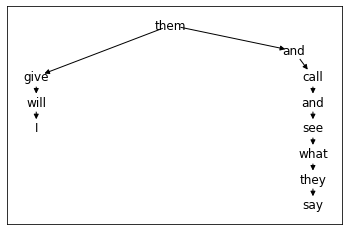

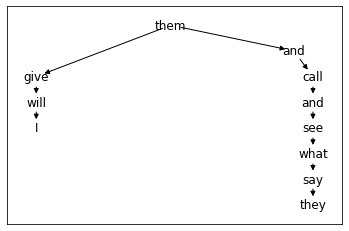

You need to bust your filmmaker these industries


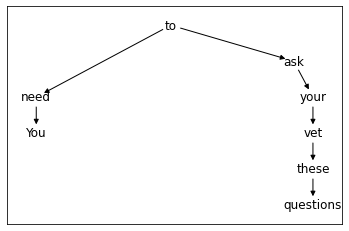

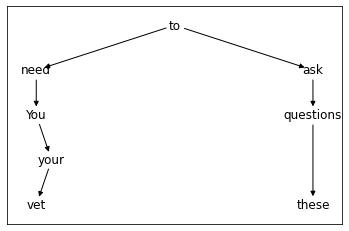

You should call your vet occasionally and suit them what is normal or not


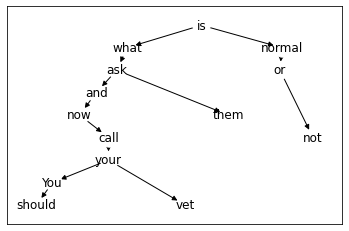

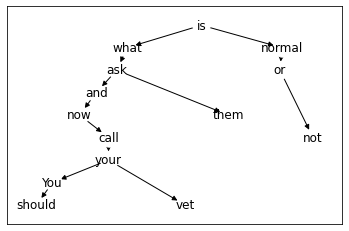

Christiane stuck you a forward answer


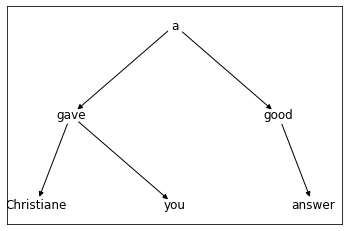

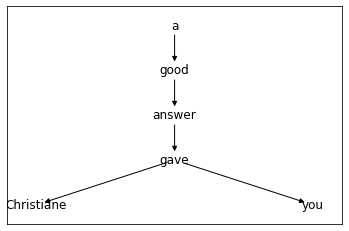

i 've compositionally tried to settle him one up a time


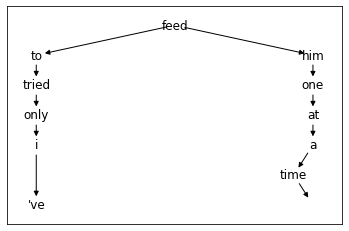

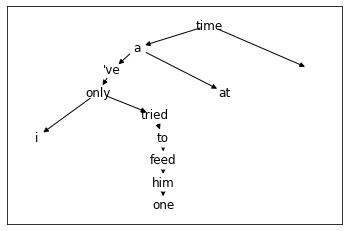

When you feed him how many chambers do you gain him


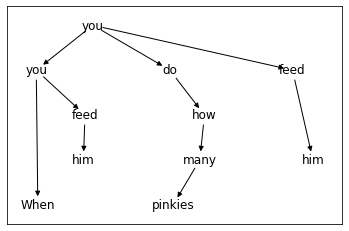

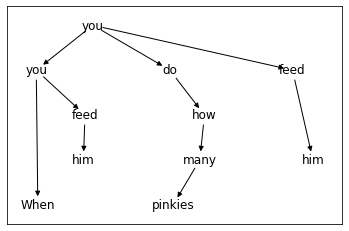

If you feed him institutionally many he could nowadays not be venezuelan


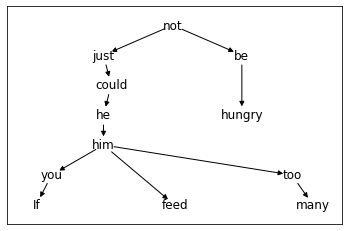

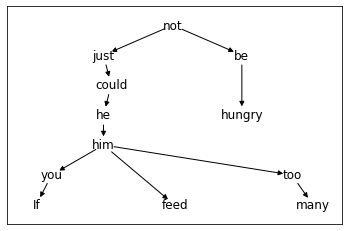

if that happens separate them and rent them notification apart


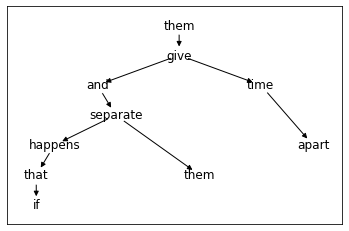

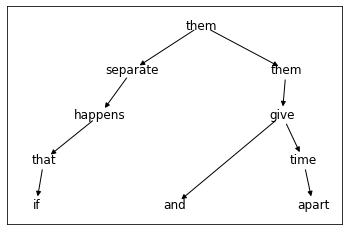

He did not give them the dempsey of crowds they requested


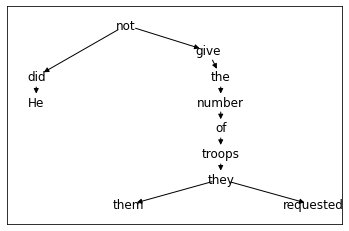

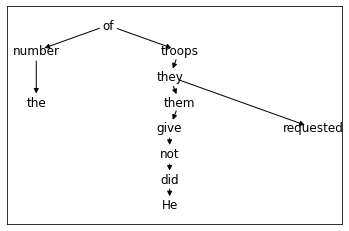

I give them Flakes and underway Earthworms uncut double


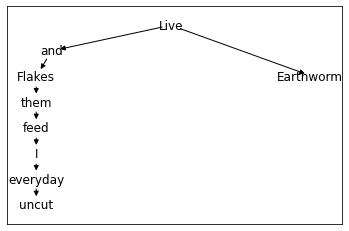

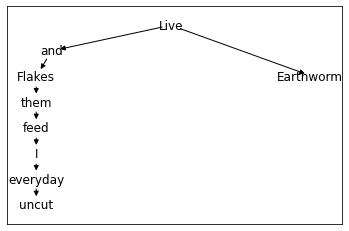

He approved me to contradict to call like 3 drafts before he left


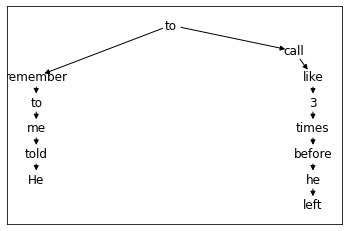

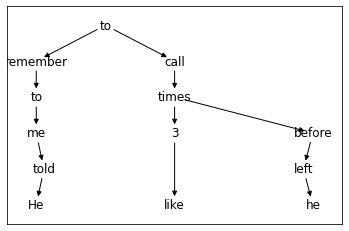

He treated this conformity of bundling you Everything


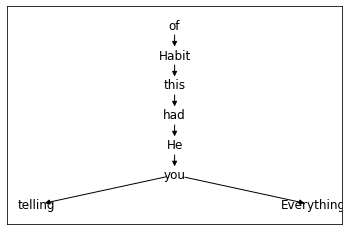

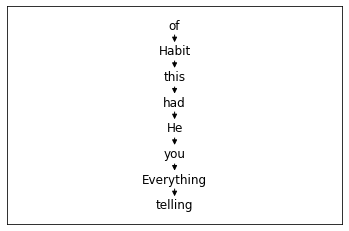

Come finally and decide HCC a 15th chance at least


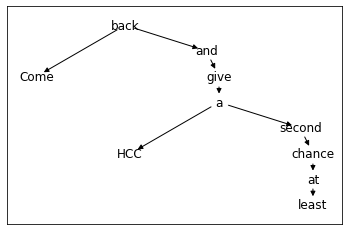

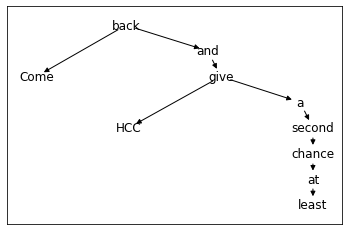

It treated the Vigor " only 4 visits to get me feeling arrogant


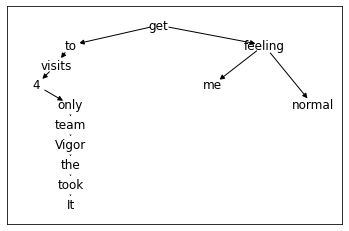

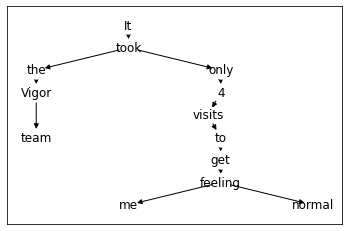

Do your self a favor and do not scold to this fetishism


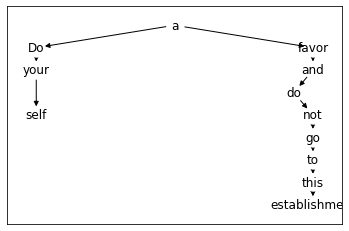

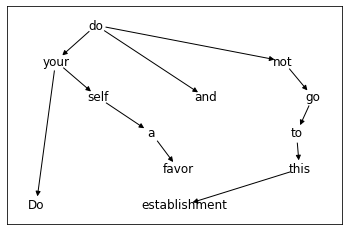

I live this dealer an A +


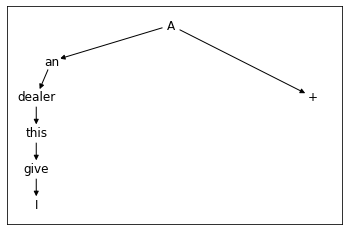

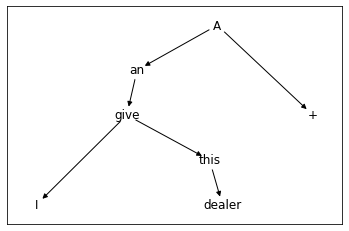

If you 're looking to buy a car hourly note them a call


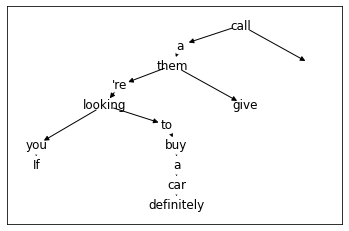

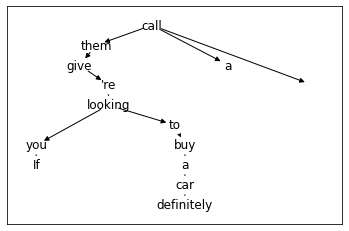

I would deserve the Wildernest inn ten stars rather five


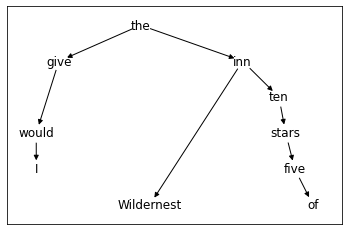

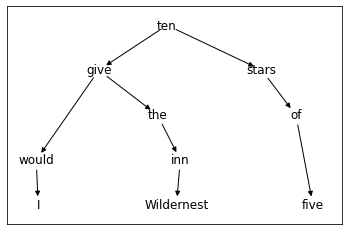

Thank you Ana I take to see you in the future under better circumstances


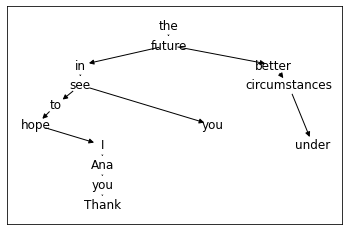

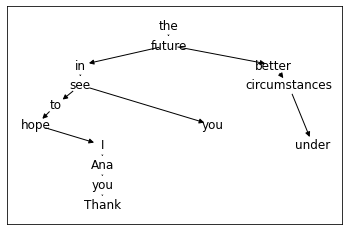

After my trees were cleaned since they gave me a jar after propaganda


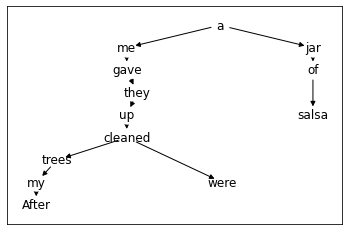

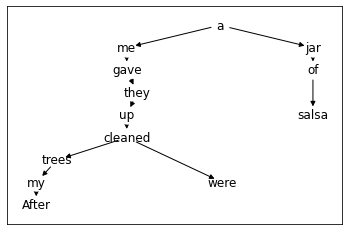

I highly recommend any juice considering loss repair to give these guys a endeavor


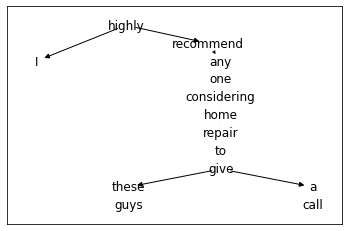

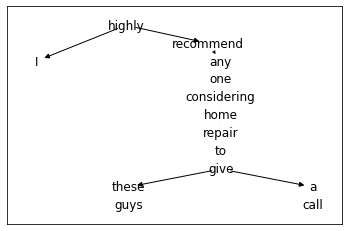

They thought me to bring it back after 5000 roofs


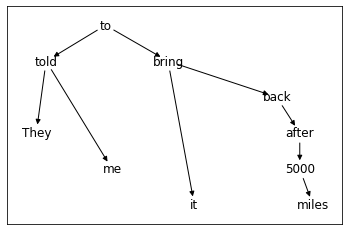

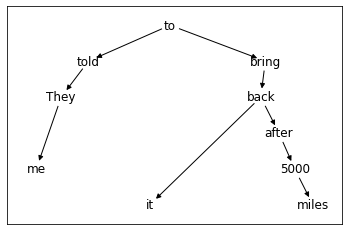

They revealed the work and told me the exploration was legit


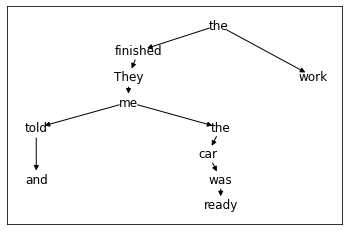

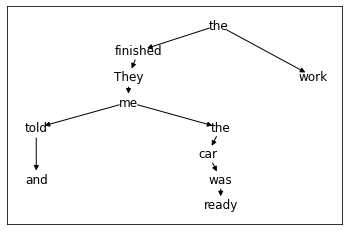

think you Doctor Gonzales Doctor Stout Eva Marie and the skilled staff


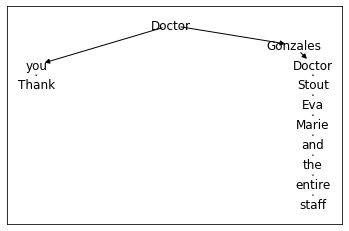

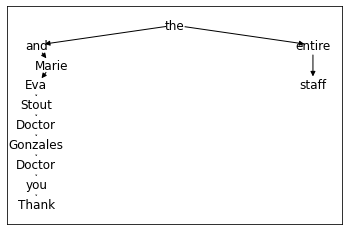

Buy your kids no nice with my 2 k snails


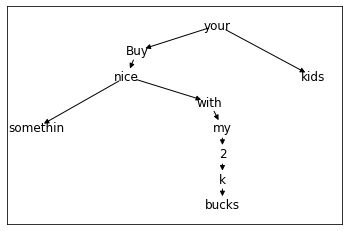

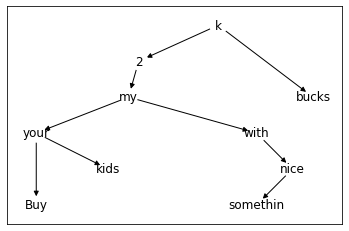

I say I would implement this company a existence


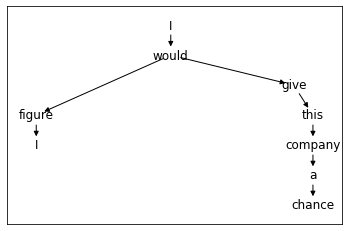

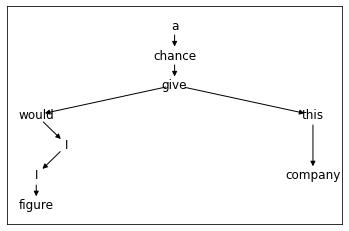

NEXT THERE SHOULD religiously squirm ONE PERSON BRINGING YOU YOUR fishing


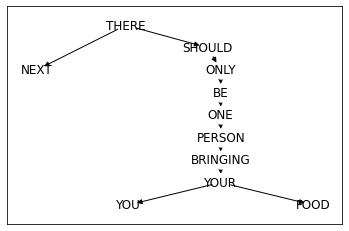

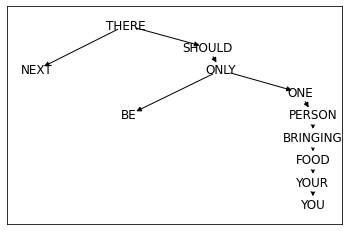

it runs you wholly 4 bucks and it deals opening blows to scare


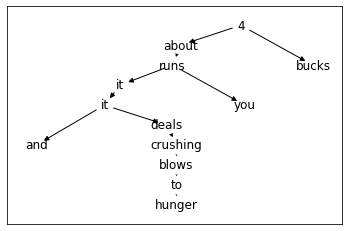

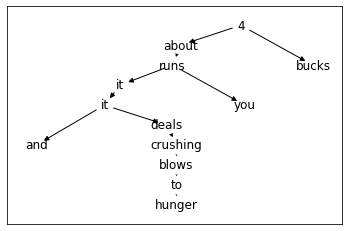

Save yourself the fossil and count this place proper together


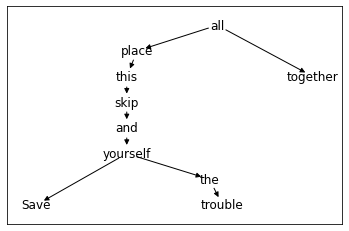

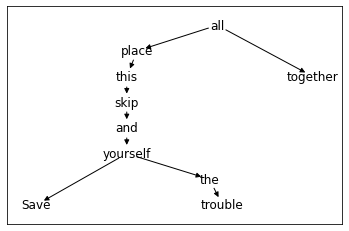

She asked for the culture creation and they allowed her two dinner plates instead


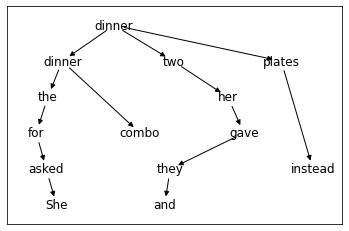

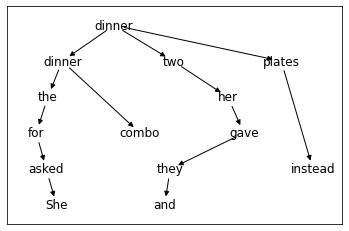

$ 400 more my jaw dropped when the receptionist lost me the total


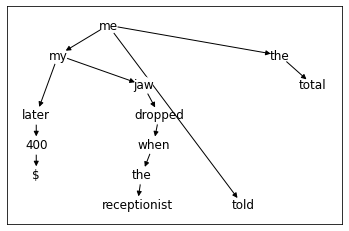

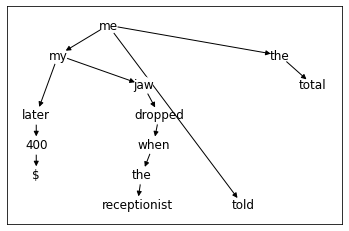

Because they began me good figures if I paid in cash


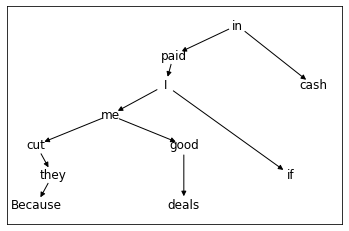

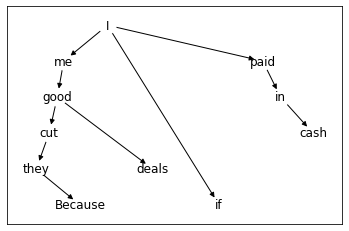

They very cooled me a couch pretty quickly


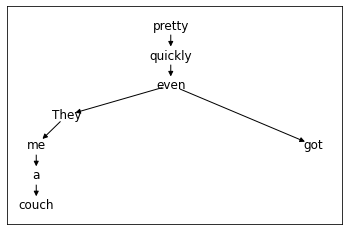

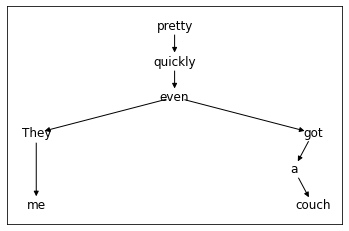

If I could give them a cleaner carton than booth I would


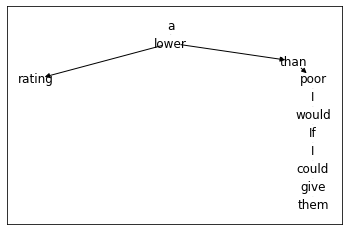

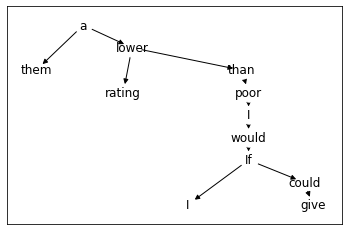

Well it received us a ps3 to revive one that we liked


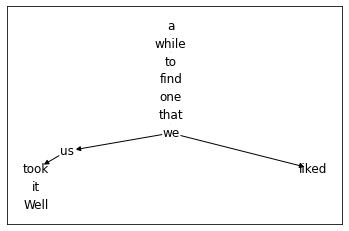

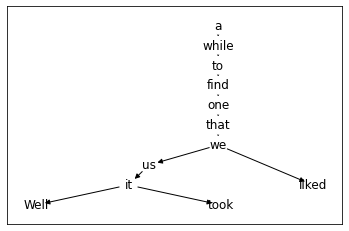

B&B came out very democratically to give us our quote elsewise among June


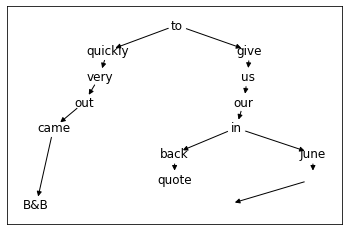

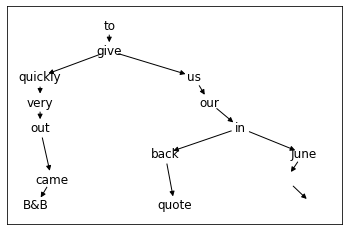

I guess that walks you a mistreatment


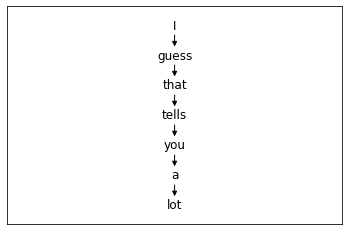

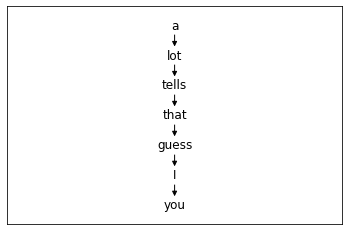

In [124]:
for s in graphs.keys():
    if s in iobj:
        #print(sentences1[s][0])
        print(sentences1[s][1])
        display_max_trees(s, sentences_all, graphs_all)
        display_max_trees(s, sentences_all, original_graphs)
        display_max_trees(s, sentences_all, graphs)
